# Data Loading and Processing

In [1]:
!pip install torch==2.2.1+cu121 torchvision==0.17.1+cu121 -f https://download.pytorch.org/whl/cu121/torch_stable.html
!pip install torchvision
!pip install torchmetrics

Looking in links: https://download.pytorch.org/whl/cu121/torch_stable.html


In [2]:
import os
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader, random_split

In [3]:
# Resize the images
transform = transforms.Compose([
    Resize((180, 180)),
    ToTensor()
])

# Loading data by ImageFolder, ImageFolder can make a label for images their folders
dataset = ImageFolder(root='images_original', transform=transform)

# Def the train set, validation set and test set
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Random split the data to training set, validation set and test set 
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create Dataloader Batch Size = 32, tried 64 but 32 better
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


# Build classifiers

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchmetrics
from tqdm import tqdm
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt
import seaborn as sns

## Net 1 (Fully Connected Network with Two Hidden Layers)

In [5]:
# Def Fully Connected Network
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super(FullyConnectedNet, self).__init__()
        self.flatten = nn.Flatten() # To 1-dimensional
        self.fc1 = nn.Linear(3 * 180 * 180, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, len(dataset.classes))

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

### Epochs = 50 (Model 1)

In [6]:
# model 1
model1 = FullyConnectedNet().cuda()

# Def Optimizer,Loss Function
# 0.001 has significantly loss fluctuations, 0.0001 loss decrease too slow
# So 0.0005
optimizer = Adam(model1.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()
batch_size = 32

# Def accuracy
def get_accuracy(dataloader, model1):
    accuracy = MulticlassAccuracy(10).cuda()
    total = 0
    correct = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model1(imgs)
        # The second return value is the index of the max i.e., argmax
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        accuracy.update(outputs, labels)

    return (correct / total).item(), accuracy.compute().item()

In [7]:
# Training model for 50 epochs
epochs = 50
for epoch in range(epochs):
    model1.train()
    loop = tqdm(train_loader)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
    epoch_loss = 0.
    for imgs, labels in loop:
        imgs, labels = imgs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model1(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss=0.9*epoch_loss+0.1*loss.item()
        loop.set_postfix(loss=epoch_loss)
    
# Caculate the Val Accuracy
    _,acc = get_accuracy(val_loader, model1)
    print(f"Loss: {epoch_loss:.4f},  Val Accuracy: {acc:.4f}")

Epoch [1/50]: 100%|██████████| 22/22 [00:02<00:00,  9.61it/s, loss=3.05]


Loss: 3.0482,  Val Accuracy: 0.1436


Epoch [2/50]: 100%|██████████| 22/22 [00:01<00:00, 11.32it/s, loss=2.03]


Loss: 2.0339,  Val Accuracy: 0.2282


Epoch [3/50]: 100%|██████████| 22/22 [00:01<00:00, 11.36it/s, loss=1.81]


Loss: 1.8060,  Val Accuracy: 0.2661


Epoch [4/50]: 100%|██████████| 22/22 [00:01<00:00, 11.27it/s, loss=1.92]


Loss: 1.9205,  Val Accuracy: 0.3511


Epoch [5/50]: 100%|██████████| 22/22 [00:02<00:00, 10.53it/s, loss=1.72]


Loss: 1.7224,  Val Accuracy: 0.2746


Epoch [6/50]: 100%|██████████| 22/22 [00:02<00:00, 10.08it/s, loss=1.65]


Loss: 1.6499,  Val Accuracy: 0.3429


Epoch [7/50]: 100%|██████████| 22/22 [00:02<00:00,  9.77it/s, loss=1.53]


Loss: 1.5312,  Val Accuracy: 0.3656


Epoch [8/50]: 100%|██████████| 22/22 [00:02<00:00, 10.04it/s, loss=1.57]


Loss: 1.5718,  Val Accuracy: 0.3261


Epoch [9/50]: 100%|██████████| 22/22 [00:02<00:00,  9.16it/s, loss=1.43]


Loss: 1.4339,  Val Accuracy: 0.3215


Epoch [10/50]: 100%|██████████| 22/22 [00:02<00:00,  9.91it/s, loss=1.41]


Loss: 1.4140,  Val Accuracy: 0.4032


Epoch [11/50]: 100%|██████████| 22/22 [00:02<00:00,  9.98it/s, loss=1.38]


Loss: 1.3816,  Val Accuracy: 0.3775


Epoch [12/50]: 100%|██████████| 22/22 [00:02<00:00,  9.91it/s, loss=1.31] 


Loss: 1.3114,  Val Accuracy: 0.4408


Epoch [13/50]: 100%|██████████| 22/22 [00:02<00:00,  9.07it/s, loss=1.3]  


Loss: 1.2966,  Val Accuracy: 0.4666


Epoch [14/50]: 100%|██████████| 22/22 [00:02<00:00,  9.59it/s, loss=1.11] 


Loss: 1.1091,  Val Accuracy: 0.4922


Epoch [15/50]: 100%|██████████| 22/22 [00:02<00:00,  9.58it/s, loss=1.11] 


Loss: 1.1102,  Val Accuracy: 0.5143


Epoch [16/50]: 100%|██████████| 22/22 [00:02<00:00,  9.78it/s, loss=1.04] 


Loss: 1.0391,  Val Accuracy: 0.4401


Epoch [17/50]: 100%|██████████| 22/22 [00:02<00:00, 10.06it/s, loss=1.01] 


Loss: 1.0096,  Val Accuracy: 0.4736


Epoch [18/50]: 100%|██████████| 22/22 [00:02<00:00,  9.53it/s, loss=0.923]


Loss: 0.9231,  Val Accuracy: 0.4363


Epoch [19/50]: 100%|██████████| 22/22 [00:02<00:00, 10.03it/s, loss=0.903]


Loss: 0.9032,  Val Accuracy: 0.4640


Epoch [20/50]: 100%|██████████| 22/22 [00:02<00:00, 10.01it/s, loss=0.823]


Loss: 0.8229,  Val Accuracy: 0.4304


Epoch [21/50]: 100%|██████████| 22/22 [00:02<00:00,  9.91it/s, loss=0.991]


Loss: 0.9915,  Val Accuracy: 0.4525


Epoch [22/50]: 100%|██████████| 22/22 [00:02<00:00, 10.09it/s, loss=0.789]


Loss: 0.7893,  Val Accuracy: 0.4120


Epoch [23/50]: 100%|██████████| 22/22 [00:02<00:00, 10.02it/s, loss=0.703]


Loss: 0.7026,  Val Accuracy: 0.5098


Epoch [24/50]: 100%|██████████| 22/22 [00:02<00:00,  9.73it/s, loss=0.663]


Loss: 0.6629,  Val Accuracy: 0.4496


Epoch [25/50]: 100%|██████████| 22/22 [00:02<00:00,  9.98it/s, loss=0.575]


Loss: 0.5754,  Val Accuracy: 0.5055


Epoch [26/50]: 100%|██████████| 22/22 [00:02<00:00,  9.76it/s, loss=0.572]


Loss: 0.5717,  Val Accuracy: 0.4759


Epoch [27/50]: 100%|██████████| 22/22 [00:02<00:00, 10.09it/s, loss=0.591]


Loss: 0.5908,  Val Accuracy: 0.4499


Epoch [28/50]: 100%|██████████| 22/22 [00:02<00:00, 10.06it/s, loss=0.504]


Loss: 0.5037,  Val Accuracy: 0.4931


Epoch [29/50]: 100%|██████████| 22/22 [00:02<00:00,  9.96it/s, loss=0.417]


Loss: 0.4167,  Val Accuracy: 0.4238


Epoch [30/50]: 100%|██████████| 22/22 [00:02<00:00,  9.85it/s, loss=0.608]


Loss: 0.6084,  Val Accuracy: 0.4299


Epoch [31/50]: 100%|██████████| 22/22 [00:02<00:00, 10.13it/s, loss=0.595]


Loss: 0.5952,  Val Accuracy: 0.4780


Epoch [32/50]: 100%|██████████| 22/22 [00:02<00:00, 10.07it/s, loss=0.366]


Loss: 0.3665,  Val Accuracy: 0.4952


Epoch [33/50]: 100%|██████████| 22/22 [00:02<00:00,  9.84it/s, loss=0.313]


Loss: 0.3126,  Val Accuracy: 0.4787


Epoch [34/50]: 100%|██████████| 22/22 [00:02<00:00,  9.96it/s, loss=0.38] 


Loss: 0.3799,  Val Accuracy: 0.5111


Epoch [35/50]: 100%|██████████| 22/22 [00:02<00:00, 10.02it/s, loss=0.268]


Loss: 0.2678,  Val Accuracy: 0.4510


Epoch [36/50]: 100%|██████████| 22/22 [00:02<00:00,  9.54it/s, loss=0.223]


Loss: 0.2233,  Val Accuracy: 0.4891


Epoch [37/50]: 100%|██████████| 22/22 [00:02<00:00,  9.98it/s, loss=0.186]


Loss: 0.1857,  Val Accuracy: 0.4913


Epoch [38/50]: 100%|██████████| 22/22 [00:02<00:00,  9.88it/s, loss=0.146]


Loss: 0.1462,  Val Accuracy: 0.5249


Epoch [39/50]: 100%|██████████| 22/22 [00:02<00:00,  9.88it/s, loss=0.153] 


Loss: 0.1533,  Val Accuracy: 0.5192


Epoch [40/50]: 100%|██████████| 22/22 [00:02<00:00,  9.80it/s, loss=0.257]


Loss: 0.2573,  Val Accuracy: 0.4681


Epoch [41/50]: 100%|██████████| 22/22 [00:02<00:00,  9.69it/s, loss=0.331]


Loss: 0.3311,  Val Accuracy: 0.5024


Epoch [42/50]: 100%|██████████| 22/22 [00:02<00:00,  9.64it/s, loss=0.148]


Loss: 0.1483,  Val Accuracy: 0.5391


Epoch [43/50]: 100%|██████████| 22/22 [00:02<00:00,  9.70it/s, loss=0.0943]


Loss: 0.0943,  Val Accuracy: 0.5095


Epoch [44/50]: 100%|██████████| 22/22 [00:02<00:00,  9.80it/s, loss=0.0913]


Loss: 0.0913,  Val Accuracy: 0.5308


Epoch [45/50]: 100%|██████████| 22/22 [00:02<00:00,  9.90it/s, loss=0.0991]


Loss: 0.0991,  Val Accuracy: 0.5488


Epoch [46/50]: 100%|██████████| 22/22 [00:02<00:00,  9.74it/s, loss=0.0666]


Loss: 0.0666,  Val Accuracy: 0.5241


Epoch [47/50]: 100%|██████████| 22/22 [00:02<00:00,  9.73it/s, loss=0.0646]


Loss: 0.0646,  Val Accuracy: 0.4821


Epoch [48/50]: 100%|██████████| 22/22 [00:02<00:00,  9.73it/s, loss=0.162] 


Loss: 0.1619,  Val Accuracy: 0.5476


Epoch [49/50]: 100%|██████████| 22/22 [00:02<00:00,  9.82it/s, loss=0.181]


Loss: 0.1810,  Val Accuracy: 0.5005


Epoch [50/50]: 100%|██████████| 22/22 [00:02<00:00,  9.70it/s, loss=0.137] 


Loss: 0.1375,  Val Accuracy: 0.5422


In [8]:
#Def Test Accuracy
def test_model(model1, test_loader):
    model1.eval()  # Evaluate mode
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model1(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy

test_accuracy = test_model(model1, test_loader)

Test Accuracy: 0.5050


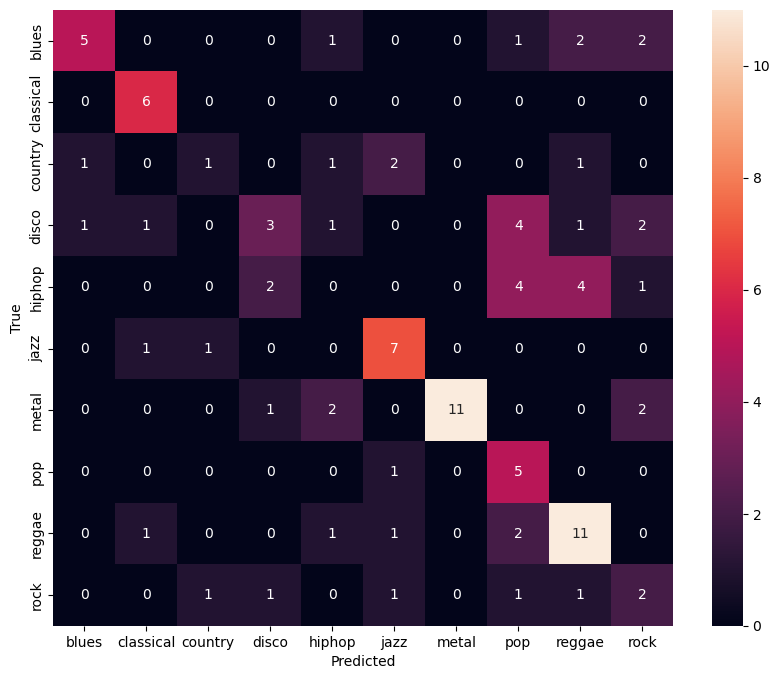

In [10]:
# Create confusion matrix
def get_confusion_matrix(model1, test_loader, num_classes):
    model1.eval()
    confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='multiclass')
    confusion_matrix.cuda()  #
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model1(images)
            _, predicted = torch.max(outputs, 1)
            confusion_matrix.update(predicted, labels)

    return confusion_matrix.compute().cpu().numpy()

# Make sure put the right number in it
num_classes = len(dataset.classes) 
conf_matrix = get_confusion_matrix(model1, test_loader, num_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Epochs = 100 (Model 2)

In [11]:
# model2
model2 = FullyConnectedNet().cuda()

# Def Optimizer,Loss Function
# 0.0001 has significantly loss fluctuations, 0.00001 loss decrease too slow
# So 0.00005
optimizer = Adam(model2.parameters(), lr=0.00005)
loss_fn = nn.CrossEntropyLoss()
bitch_size = 32

# Def accuracy
def get_accuracy(dataloader, model2):
    accuracy = MulticlassAccuracy(10).cuda()
    total = 0
    correct = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model2(imgs)
        # The second return value is the index of the max i.e., argmax
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        accuracy.update(outputs, labels)

    return (correct / total).item(), accuracy.compute().item()

In [12]:
# Training model for 100 epochs
epochs = 100
for epoch in range(epochs):
    model2.train()
    loop = tqdm(train_loader)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
    epoch_loss = 0.
    for imgs, labels in loop:
        imgs, labels = imgs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model2(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss=0.9*epoch_loss+0.1*loss.item()
        loop.set_postfix(loss=epoch_loss)
    
# Caculate the Val Accuracy
    _,acc = get_accuracy(val_loader, model2)
    print(f"Loss: {epoch_loss:.4f},  Val Accuracy: {acc:.4f}")

Epoch [1/100]: 100%|██████████| 22/22 [00:02<00:00,  9.42it/s, loss=2.03]


Loss: 2.0350,  Val Accuracy: 0.1863


Epoch [2/100]: 100%|██████████| 22/22 [00:02<00:00,  9.84it/s, loss=1.87]


Loss: 1.8743,  Val Accuracy: 0.2628


Epoch [3/100]: 100%|██████████| 22/22 [00:02<00:00,  9.43it/s, loss=1.87]


Loss: 1.8655,  Val Accuracy: 0.2577


Epoch [4/100]: 100%|██████████| 22/22 [00:02<00:00,  9.26it/s, loss=1.82]


Loss: 1.8186,  Val Accuracy: 0.2774


Epoch [5/100]: 100%|██████████| 22/22 [00:02<00:00,  9.23it/s, loss=1.76]


Loss: 1.7643,  Val Accuracy: 0.3206


Epoch [6/100]: 100%|██████████| 22/22 [00:02<00:00,  8.96it/s, loss=1.78]


Loss: 1.7795,  Val Accuracy: 0.3581


Epoch [7/100]: 100%|██████████| 22/22 [00:02<00:00, 10.07it/s, loss=1.64]


Loss: 1.6439,  Val Accuracy: 0.3962


Epoch [8/100]: 100%|██████████| 22/22 [00:02<00:00, 10.08it/s, loss=1.65]


Loss: 1.6466,  Val Accuracy: 0.3445


Epoch [9/100]: 100%|██████████| 22/22 [00:02<00:00,  9.83it/s, loss=1.6] 


Loss: 1.5958,  Val Accuracy: 0.3522


Epoch [10/100]: 100%|██████████| 22/22 [00:02<00:00, 10.12it/s, loss=1.5] 


Loss: 1.4985,  Val Accuracy: 0.4362


Epoch [11/100]: 100%|██████████| 22/22 [00:02<00:00, 10.07it/s, loss=1.47]


Loss: 1.4715,  Val Accuracy: 0.3479


Epoch [12/100]: 100%|██████████| 22/22 [00:02<00:00, 10.08it/s, loss=1.44]


Loss: 1.4365,  Val Accuracy: 0.3650


Epoch [13/100]: 100%|██████████| 22/22 [00:02<00:00, 10.12it/s, loss=1.43]


Loss: 1.4299,  Val Accuracy: 0.3742


Epoch [14/100]: 100%|██████████| 22/22 [00:02<00:00,  9.85it/s, loss=1.41] 


Loss: 1.4055,  Val Accuracy: 0.3791


Epoch [15/100]: 100%|██████████| 22/22 [00:02<00:00,  9.78it/s, loss=1.33] 


Loss: 1.3346,  Val Accuracy: 0.3660


Epoch [16/100]: 100%|██████████| 22/22 [00:02<00:00, 10.05it/s, loss=1.34] 


Loss: 1.3429,  Val Accuracy: 0.4148


Epoch [17/100]: 100%|██████████| 22/22 [00:02<00:00,  9.92it/s, loss=1.37] 


Loss: 1.3721,  Val Accuracy: 0.4687


Epoch [18/100]: 100%|██████████| 22/22 [00:02<00:00,  9.98it/s, loss=1.27] 


Loss: 1.2699,  Val Accuracy: 0.4914


Epoch [19/100]: 100%|██████████| 22/22 [00:02<00:00, 10.10it/s, loss=1.25] 


Loss: 1.2489,  Val Accuracy: 0.4765


Epoch [20/100]: 100%|██████████| 22/22 [00:02<00:00,  9.94it/s, loss=1.23] 


Loss: 1.2335,  Val Accuracy: 0.4947


Epoch [21/100]: 100%|██████████| 22/22 [00:02<00:00,  9.78it/s, loss=1.21] 


Loss: 1.2095,  Val Accuracy: 0.4769


Epoch [22/100]: 100%|██████████| 22/22 [00:02<00:00,  9.91it/s, loss=1.16] 


Loss: 1.1635,  Val Accuracy: 0.4164


Epoch [23/100]: 100%|██████████| 22/22 [00:02<00:00, 10.14it/s, loss=1.15] 


Loss: 1.1490,  Val Accuracy: 0.4830


Epoch [24/100]: 100%|██████████| 22/22 [00:02<00:00, 10.05it/s, loss=1.1]  


Loss: 1.0980,  Val Accuracy: 0.4412


Epoch [25/100]: 100%|██████████| 22/22 [00:02<00:00, 10.08it/s, loss=1.12] 


Loss: 1.1162,  Val Accuracy: 0.4660


Epoch [26/100]: 100%|██████████| 22/22 [00:02<00:00,  9.89it/s, loss=1.03] 


Loss: 1.0328,  Val Accuracy: 0.4731


Epoch [27/100]: 100%|██████████| 22/22 [00:02<00:00,  9.89it/s, loss=1.04] 


Loss: 1.0446,  Val Accuracy: 0.4613


Epoch [28/100]: 100%|██████████| 22/22 [00:02<00:00, 10.03it/s, loss=1.01] 


Loss: 1.0052,  Val Accuracy: 0.4877


Epoch [29/100]: 100%|██████████| 22/22 [00:02<00:00,  9.96it/s, loss=1.04] 


Loss: 1.0395,  Val Accuracy: 0.3870


Epoch [30/100]: 100%|██████████| 22/22 [00:02<00:00, 10.09it/s, loss=0.988]


Loss: 0.9882,  Val Accuracy: 0.4984


Epoch [31/100]: 100%|██████████| 22/22 [00:02<00:00,  9.97it/s, loss=0.972]


Loss: 0.9719,  Val Accuracy: 0.5263


Epoch [32/100]: 100%|██████████| 22/22 [00:02<00:00,  9.62it/s, loss=0.979]


Loss: 0.9792,  Val Accuracy: 0.4519


Epoch [33/100]: 100%|██████████| 22/22 [00:02<00:00,  9.95it/s, loss=0.892]


Loss: 0.8918,  Val Accuracy: 0.4282


Epoch [34/100]: 100%|██████████| 22/22 [00:02<00:00, 10.07it/s, loss=0.887]


Loss: 0.8867,  Val Accuracy: 0.4943


Epoch [35/100]: 100%|██████████| 22/22 [00:02<00:00,  9.97it/s, loss=0.829]


Loss: 0.8293,  Val Accuracy: 0.4525


Epoch [36/100]: 100%|██████████| 22/22 [00:02<00:00,  9.95it/s, loss=0.835]


Loss: 0.8354,  Val Accuracy: 0.5261


Epoch [37/100]: 100%|██████████| 22/22 [00:02<00:00, 10.00it/s, loss=0.798]


Loss: 0.7982,  Val Accuracy: 0.4815


Epoch [38/100]: 100%|██████████| 22/22 [00:02<00:00,  9.85it/s, loss=0.813]


Loss: 0.8131,  Val Accuracy: 0.4991


Epoch [39/100]: 100%|██████████| 22/22 [00:02<00:00,  9.83it/s, loss=0.776]


Loss: 0.7759,  Val Accuracy: 0.4357


Epoch [40/100]: 100%|██████████| 22/22 [00:02<00:00,  9.78it/s, loss=0.755]


Loss: 0.7553,  Val Accuracy: 0.5589


Epoch [41/100]: 100%|██████████| 22/22 [00:02<00:00,  9.86it/s, loss=0.744]


Loss: 0.7444,  Val Accuracy: 0.4582


Epoch [42/100]: 100%|██████████| 22/22 [00:02<00:00,  9.88it/s, loss=0.713]


Loss: 0.7134,  Val Accuracy: 0.4809


Epoch [43/100]: 100%|██████████| 22/22 [00:02<00:00,  9.94it/s, loss=0.701]


Loss: 0.7014,  Val Accuracy: 0.4656


Epoch [44/100]: 100%|██████████| 22/22 [00:02<00:00,  9.15it/s, loss=0.682]


Loss: 0.6824,  Val Accuracy: 0.4383


Epoch [45/100]: 100%|██████████| 22/22 [00:02<00:00,  9.06it/s, loss=0.662]


Loss: 0.6617,  Val Accuracy: 0.5042


Epoch [46/100]: 100%|██████████| 22/22 [00:02<00:00,  9.70it/s, loss=0.649]


Loss: 0.6494,  Val Accuracy: 0.5108


Epoch [47/100]: 100%|██████████| 22/22 [00:02<00:00,  9.49it/s, loss=0.597]


Loss: 0.5972,  Val Accuracy: 0.5186


Epoch [48/100]: 100%|██████████| 22/22 [00:02<00:00,  8.97it/s, loss=0.583]


Loss: 0.5830,  Val Accuracy: 0.5158


Epoch [49/100]: 100%|██████████| 22/22 [00:02<00:00,  9.38it/s, loss=0.557]


Loss: 0.5567,  Val Accuracy: 0.5413


Epoch [50/100]: 100%|██████████| 22/22 [00:02<00:00,  9.45it/s, loss=0.537]


Loss: 0.5374,  Val Accuracy: 0.5455


Epoch [51/100]: 100%|██████████| 22/22 [00:02<00:00,  9.80it/s, loss=0.556]


Loss: 0.5563,  Val Accuracy: 0.5172


Epoch [52/100]: 100%|██████████| 22/22 [00:02<00:00,  9.84it/s, loss=0.526]


Loss: 0.5256,  Val Accuracy: 0.5029


Epoch [53/100]: 100%|██████████| 22/22 [00:02<00:00,  9.78it/s, loss=0.524]


Loss: 0.5238,  Val Accuracy: 0.5458


Epoch [54/100]: 100%|██████████| 22/22 [00:02<00:00,  9.80it/s, loss=0.452]


Loss: 0.4519,  Val Accuracy: 0.5642


Epoch [55/100]: 100%|██████████| 22/22 [00:02<00:00,  9.68it/s, loss=0.446]


Loss: 0.4456,  Val Accuracy: 0.5455


Epoch [56/100]: 100%|██████████| 22/22 [00:02<00:00,  9.71it/s, loss=0.45] 


Loss: 0.4499,  Val Accuracy: 0.5253


Epoch [57/100]: 100%|██████████| 22/22 [00:02<00:00,  9.83it/s, loss=0.444]


Loss: 0.4437,  Val Accuracy: 0.5400


Epoch [58/100]: 100%|██████████| 22/22 [00:02<00:00,  9.84it/s, loss=0.413]


Loss: 0.4131,  Val Accuracy: 0.5623


Epoch [59/100]: 100%|██████████| 22/22 [00:02<00:00,  9.92it/s, loss=0.396]


Loss: 0.3961,  Val Accuracy: 0.4779


Epoch [60/100]: 100%|██████████| 22/22 [00:02<00:00,  9.86it/s, loss=0.395]


Loss: 0.3952,  Val Accuracy: 0.5688


Epoch [61/100]: 100%|██████████| 22/22 [00:02<00:00,  9.59it/s, loss=0.398]


Loss: 0.3980,  Val Accuracy: 0.5179


Epoch [62/100]: 100%|██████████| 22/22 [00:02<00:00,  9.76it/s, loss=0.364]


Loss: 0.3637,  Val Accuracy: 0.5118


Epoch [63/100]: 100%|██████████| 22/22 [00:02<00:00,  9.79it/s, loss=0.334]


Loss: 0.3341,  Val Accuracy: 0.5465


Epoch [64/100]: 100%|██████████| 22/22 [00:02<00:00,  9.71it/s, loss=0.343]


Loss: 0.3428,  Val Accuracy: 0.5260


Epoch [65/100]: 100%|██████████| 22/22 [00:02<00:00,  9.89it/s, loss=0.325]


Loss: 0.3254,  Val Accuracy: 0.5072


Epoch [66/100]: 100%|██████████| 22/22 [00:02<00:00,  9.92it/s, loss=0.315]


Loss: 0.3152,  Val Accuracy: 0.5200


Epoch [67/100]: 100%|██████████| 22/22 [00:02<00:00,  9.43it/s, loss=0.305]


Loss: 0.3053,  Val Accuracy: 0.5125


Epoch [68/100]: 100%|██████████| 22/22 [00:02<00:00,  9.80it/s, loss=0.308]


Loss: 0.3075,  Val Accuracy: 0.5482


Epoch [69/100]: 100%|██████████| 22/22 [00:02<00:00,  9.82it/s, loss=0.283]


Loss: 0.2835,  Val Accuracy: 0.5291


Epoch [70/100]: 100%|██████████| 22/22 [00:02<00:00,  9.86it/s, loss=0.261]


Loss: 0.2611,  Val Accuracy: 0.5568


Epoch [71/100]: 100%|██████████| 22/22 [00:02<00:00,  9.83it/s, loss=0.254]


Loss: 0.2544,  Val Accuracy: 0.5081


Epoch [72/100]: 100%|██████████| 22/22 [00:02<00:00,  9.85it/s, loss=0.256]


Loss: 0.2563,  Val Accuracy: 0.5735


Epoch [73/100]: 100%|██████████| 22/22 [00:02<00:00,  9.59it/s, loss=0.232]


Loss: 0.2321,  Val Accuracy: 0.5212


Epoch [74/100]: 100%|██████████| 22/22 [00:02<00:00,  9.91it/s, loss=0.23] 


Loss: 0.2297,  Val Accuracy: 0.5542


Epoch [75/100]: 100%|██████████| 22/22 [00:02<00:00,  9.90it/s, loss=0.218]


Loss: 0.2184,  Val Accuracy: 0.5607


Epoch [76/100]: 100%|██████████| 22/22 [00:02<00:00,  9.82it/s, loss=0.227]


Loss: 0.2267,  Val Accuracy: 0.5785


Epoch [77/100]: 100%|██████████| 22/22 [00:02<00:00,  9.78it/s, loss=0.211]


Loss: 0.2113,  Val Accuracy: 0.5314


Epoch [78/100]: 100%|██████████| 22/22 [00:02<00:00,  9.69it/s, loss=0.198]


Loss: 0.1985,  Val Accuracy: 0.5739


Epoch [79/100]: 100%|██████████| 22/22 [00:02<00:00,  9.64it/s, loss=0.193]


Loss: 0.1926,  Val Accuracy: 0.5045


Epoch [80/100]: 100%|██████████| 22/22 [00:02<00:00,  9.74it/s, loss=0.189]


Loss: 0.1893,  Val Accuracy: 0.5630


Epoch [81/100]: 100%|██████████| 22/22 [00:02<00:00,  9.74it/s, loss=0.189]


Loss: 0.1895,  Val Accuracy: 0.5754


Epoch [82/100]: 100%|██████████| 22/22 [00:02<00:00,  9.85it/s, loss=0.169]


Loss: 0.1689,  Val Accuracy: 0.5055


Epoch [83/100]: 100%|██████████| 22/22 [00:02<00:00,  9.91it/s, loss=0.173]


Loss: 0.1731,  Val Accuracy: 0.5301


Epoch [84/100]: 100%|██████████| 22/22 [00:02<00:00,  9.63it/s, loss=0.163]


Loss: 0.1631,  Val Accuracy: 0.5843


Epoch [85/100]: 100%|██████████| 22/22 [00:02<00:00,  9.67it/s, loss=0.176]


Loss: 0.1760,  Val Accuracy: 0.5501


Epoch [86/100]: 100%|██████████| 22/22 [00:02<00:00,  9.84it/s, loss=0.157]


Loss: 0.1569,  Val Accuracy: 0.5550


Epoch [87/100]: 100%|██████████| 22/22 [00:02<00:00,  9.79it/s, loss=0.157]


Loss: 0.1566,  Val Accuracy: 0.5236


Epoch [88/100]: 100%|██████████| 22/22 [00:02<00:00,  9.80it/s, loss=0.133]


Loss: 0.1329,  Val Accuracy: 0.5834


Epoch [89/100]: 100%|██████████| 22/22 [00:02<00:00,  9.84it/s, loss=0.135] 


Loss: 0.1352,  Val Accuracy: 0.5609


Epoch [90/100]: 100%|██████████| 22/22 [00:02<00:00,  9.53it/s, loss=0.14]  


Loss: 0.1405,  Val Accuracy: 0.5310


Epoch [91/100]: 100%|██████████| 22/22 [00:02<00:00,  9.83it/s, loss=0.128] 


Loss: 0.1280,  Val Accuracy: 0.5422


Epoch [92/100]: 100%|██████████| 22/22 [00:02<00:00,  9.90it/s, loss=0.137] 


Loss: 0.1366,  Val Accuracy: 0.5615


Epoch [93/100]: 100%|██████████| 22/22 [00:02<00:00,  9.80it/s, loss=0.119] 


Loss: 0.1186,  Val Accuracy: 0.5531


Epoch [94/100]: 100%|██████████| 22/22 [00:02<00:00,  9.72it/s, loss=0.121] 


Loss: 0.1214,  Val Accuracy: 0.5633


Epoch [95/100]: 100%|██████████| 22/22 [00:02<00:00,  9.85it/s, loss=0.106] 


Loss: 0.1064,  Val Accuracy: 0.5085


Epoch [96/100]: 100%|██████████| 22/22 [00:02<00:00,  9.39it/s, loss=0.116] 


Loss: 0.1164,  Val Accuracy: 0.5179


Epoch [97/100]: 100%|██████████| 22/22 [00:02<00:00,  9.84it/s, loss=0.111] 


Loss: 0.1111,  Val Accuracy: 0.5522


Epoch [98/100]: 100%|██████████| 22/22 [00:02<00:00,  9.90it/s, loss=0.0971]


Loss: 0.0971,  Val Accuracy: 0.5504


Epoch [99/100]: 100%|██████████| 22/22 [00:02<00:00,  9.95it/s, loss=0.101] 


Loss: 0.1013,  Val Accuracy: 0.5310


Epoch [100/100]: 100%|██████████| 22/22 [00:02<00:00, 10.02it/s, loss=0.0953]


Loss: 0.0953,  Val Accuracy: 0.5317


In [13]:
#Def Test Accuracy
def test_model(model2, test_loader):
    model2.eval()  # Evaluate mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy

test_accuracy = test_model(model2, test_loader)

Test Accuracy: 0.5050


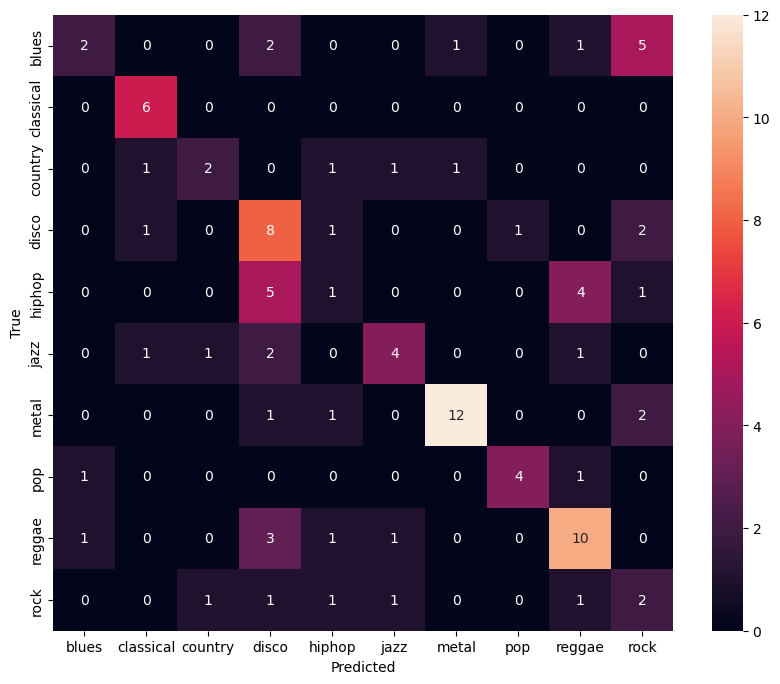

In [15]:
# Create confusion matrix
def get_confusion_matrix(model2, test_loader, num_classes):
    model2.eval()
    confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='multiclass')
    confusion_matrix.cuda() 
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model2(images)
            _, predicted = torch.max(outputs, 1)
            confusion_matrix.update(predicted, labels)

    return confusion_matrix.compute().cpu().numpy()

# Make sure put the right number in it
num_classes = len(dataset.classes)  
conf_matrix = get_confusion_matrix(model2, test_loader, num_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
torch.cuda.empty_cache() #clean gpu but not work...

## Net 2 (Convolutional Network in Figure 1)

In [18]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        # Conv1 + ReLU
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        
        # Conv2 + ReLU
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # MaxPool1
        
        # Conv3 + ReLU
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        # Conv4 + ReLU
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # MaxPool2
        
        # Fully Connected1(out_features = 256) + ReLU
        self.fc1 = nn.Linear(256 * 45 * 45, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes) # Fully Connected2

    def forward(self, x):
        # Conv1 layer, Activation Function
        x = self.relu1(self.conv1(x))
        
        # Conv2 layer, Activation Function, MaxPool1 layer
        x = self.pool1(self.relu2(self.conv2(x)))
        
        # Conv3 layer, Activation Function
        x = self.relu3(self.conv3(x))
        
        # Conv4 layer, Activation function, MaxPool2 layer
        x = self.pool2(self.relu4(self.conv4(x)))
        
        # Flattening the feature map for Fully Connected layer
        x = x.view(x.size(0), -1)
        
        # Fully Connected1 layer, Activation function
        x = self.relu5(self.fc1(x))
        
        #  Fully Connected2 layer
        x = self.fc2(x)
        return x
    
    

### Epochs = 50 (Model 3)

In [6]:
# model3
model3 = ConvNet(10).cuda()

# Def Optimizer,Loss Function
# 0.0001 has significantly loss fluctuations, 0.00001 loss decrease too slow
# So 0.00005
optimizer = Adam(model3.parameters(), lr=0.00005)
loss_fn = nn.CrossEntropyLoss()
batch_size = 32

# Def accuracy
def get_accuracy(dataloader, model3):
    accuracy = MulticlassAccuracy(10).cuda()
    total = 0
    correct = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model3(imgs)
        # The second return value is the index of the max i.e., argmax
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        accuracy.update(outputs, labels)
        
    return (correct / total).item(), accuracy.compute().item()

In [7]:
# Training model for 50 epochs
epochs = 50
for epoch in range(epochs):
    model3.train()
    loop = tqdm(train_loader)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
    epoch_loss = 0
    for imgs, labels in loop:
        imgs, labels = imgs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model3(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss=0.9*epoch_loss+0.1*loss.item()
        loop.set_postfix(loss=epoch_loss)
    
# Caculate the Val Accuracy
    _,acc = get_accuracy(val_loader, model3)
    print(f"Loss: {epoch_loss:.4f},  Val Accuracy: {acc:.4f}")

Epoch [1/50]: 100%|██████████| 22/22 [00:04<00:00,  4.52it/s, loss=2.08]


Loss: 2.0812,  Val Accuracy: 0.1817


Epoch [2/50]: 100%|██████████| 22/22 [00:04<00:00,  5.02it/s, loss=2.02]


Loss: 2.0235,  Val Accuracy: 0.1943


Epoch [3/50]: 100%|██████████| 22/22 [00:04<00:00,  5.07it/s, loss=1.91]


Loss: 1.9082,  Val Accuracy: 0.2296


Epoch [4/50]: 100%|██████████| 22/22 [00:04<00:00,  5.00it/s, loss=1.82]


Loss: 1.8217,  Val Accuracy: 0.2597


Epoch [5/50]: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s, loss=1.77]


Loss: 1.7701,  Val Accuracy: 0.2709


Epoch [6/50]: 100%|██████████| 22/22 [00:04<00:00,  5.02it/s, loss=1.77]


Loss: 1.7658,  Val Accuracy: 0.3421


Epoch [7/50]: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s, loss=1.67]


Loss: 1.6736,  Val Accuracy: 0.3519


Epoch [8/50]: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s, loss=1.63]


Loss: 1.6333,  Val Accuracy: 0.3738


Epoch [9/50]: 100%|██████████| 22/22 [00:04<00:00,  4.92it/s, loss=1.59]


Loss: 1.5856,  Val Accuracy: 0.4356


Epoch [10/50]: 100%|██████████| 22/22 [00:04<00:00,  4.86it/s, loss=1.53]


Loss: 1.5343,  Val Accuracy: 0.3815


Epoch [11/50]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=1.41]


Loss: 1.4085,  Val Accuracy: 0.3896


Epoch [12/50]: 100%|██████████| 22/22 [00:04<00:00,  4.86it/s, loss=1.33] 


Loss: 1.3280,  Val Accuracy: 0.4524


Epoch [13/50]: 100%|██████████| 22/22 [00:04<00:00,  4.83it/s, loss=1.28] 


Loss: 1.2840,  Val Accuracy: 0.4617


Epoch [14/50]: 100%|██████████| 22/22 [00:04<00:00,  4.77it/s, loss=1.22] 


Loss: 1.2244,  Val Accuracy: 0.4527


Epoch [15/50]: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s, loss=1.12] 


Loss: 1.1168,  Val Accuracy: 0.5034


Epoch [16/50]: 100%|██████████| 22/22 [00:04<00:00,  4.86it/s, loss=1.02] 


Loss: 1.0150,  Val Accuracy: 0.5071


Epoch [17/50]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.954]


Loss: 0.9542,  Val Accuracy: 0.4913


Epoch [18/50]: 100%|██████████| 22/22 [00:04<00:00,  4.87it/s, loss=0.981]


Loss: 0.9812,  Val Accuracy: 0.5143


Epoch [19/50]: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s, loss=0.847]


Loss: 0.8468,  Val Accuracy: 0.5840


Epoch [20/50]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.825]


Loss: 0.8252,  Val Accuracy: 0.5276


Epoch [21/50]: 100%|██████████| 22/22 [00:04<00:00,  4.87it/s, loss=0.853]


Loss: 0.8526,  Val Accuracy: 0.5441


Epoch [22/50]: 100%|██████████| 22/22 [00:04<00:00,  4.89it/s, loss=0.758]


Loss: 0.7584,  Val Accuracy: 0.5675


Epoch [23/50]: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s, loss=0.682]


Loss: 0.6824,  Val Accuracy: 0.5861


Epoch [24/50]: 100%|██████████| 22/22 [00:04<00:00,  4.61it/s, loss=0.613]


Loss: 0.6126,  Val Accuracy: 0.5669


Epoch [25/50]: 100%|██████████| 22/22 [00:04<00:00,  4.57it/s, loss=0.591]


Loss: 0.5907,  Val Accuracy: 0.5990


Epoch [26/50]: 100%|██████████| 22/22 [00:04<00:00,  4.71it/s, loss=0.506]


Loss: 0.5060,  Val Accuracy: 0.6206


Epoch [27/50]: 100%|██████████| 22/22 [00:04<00:00,  4.70it/s, loss=0.467]


Loss: 0.4672,  Val Accuracy: 0.6263


Epoch [28/50]: 100%|██████████| 22/22 [00:04<00:00,  4.81it/s, loss=0.441]


Loss: 0.4409,  Val Accuracy: 0.6195


Epoch [29/50]: 100%|██████████| 22/22 [00:04<00:00,  4.65it/s, loss=0.401]


Loss: 0.4011,  Val Accuracy: 0.6112


Epoch [30/50]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.359]


Loss: 0.3593,  Val Accuracy: 0.6057


Epoch [31/50]: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s, loss=0.371]


Loss: 0.3713,  Val Accuracy: 0.6237


Epoch [32/50]: 100%|██████████| 22/22 [00:04<00:00,  4.81it/s, loss=0.295]


Loss: 0.2949,  Val Accuracy: 0.6133


Epoch [33/50]: 100%|██████████| 22/22 [00:04<00:00,  4.92it/s, loss=0.247]


Loss: 0.2475,  Val Accuracy: 0.6099


Epoch [34/50]: 100%|██████████| 22/22 [00:04<00:00,  4.94it/s, loss=0.257]


Loss: 0.2574,  Val Accuracy: 0.6061


Epoch [35/50]: 100%|██████████| 22/22 [00:04<00:00,  4.67it/s, loss=0.229]


Loss: 0.2292,  Val Accuracy: 0.6100


Epoch [36/50]: 100%|██████████| 22/22 [00:04<00:00,  4.93it/s, loss=0.156]


Loss: 0.1556,  Val Accuracy: 0.6247


Epoch [37/50]: 100%|██████████| 22/22 [00:04<00:00,  4.96it/s, loss=0.153]


Loss: 0.1528,  Val Accuracy: 0.6174


Epoch [38/50]: 100%|██████████| 22/22 [00:04<00:00,  4.83it/s, loss=0.141] 


Loss: 0.1406,  Val Accuracy: 0.6244


Epoch [39/50]: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s, loss=0.114] 


Loss: 0.1137,  Val Accuracy: 0.6189


Epoch [40/50]: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s, loss=0.11]  


Loss: 0.1098,  Val Accuracy: 0.6417


Epoch [41/50]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.0956]


Loss: 0.0956,  Val Accuracy: 0.6018


Epoch [42/50]: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s, loss=0.0889]


Loss: 0.0889,  Val Accuracy: 0.5842


Epoch [43/50]: 100%|██████████| 22/22 [00:04<00:00,  4.86it/s, loss=0.0862]


Loss: 0.0862,  Val Accuracy: 0.6425


Epoch [44/50]: 100%|██████████| 22/22 [00:04<00:00,  4.81it/s, loss=0.0805]


Loss: 0.0805,  Val Accuracy: 0.6440


Epoch [45/50]: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s, loss=0.065] 


Loss: 0.0650,  Val Accuracy: 0.6328


Epoch [46/50]: 100%|██████████| 22/22 [00:04<00:00,  4.87it/s, loss=0.0548]


Loss: 0.0548,  Val Accuracy: 0.6213


Epoch [47/50]: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s, loss=0.0596]


Loss: 0.0596,  Val Accuracy: 0.5897


Epoch [48/50]: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s, loss=0.11]  


Loss: 0.1104,  Val Accuracy: 0.6350


Epoch [49/50]: 100%|██████████| 22/22 [00:04<00:00,  4.68it/s, loss=0.0521]


Loss: 0.0521,  Val Accuracy: 0.6419


Epoch [50/50]: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s, loss=0.0354]


Loss: 0.0354,  Val Accuracy: 0.6313


In [8]:
# Def Test Accuracy
def test_model(model3, test_loader):
    model3.eval()  # Evaluate mode
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model3(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy

test_accuracy = test_model(model3, test_loader)

Test Accuracy: 0.6238


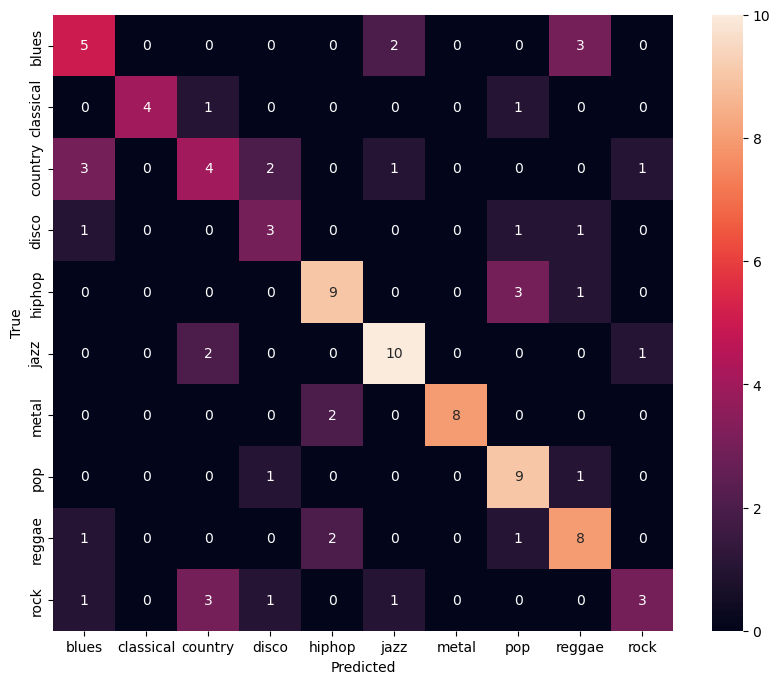

In [9]:
# Create confusion matrix
def get_confusion_matrix(model3, test_loader, num_classes):
    model3.eval()
    confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='multiclass')
    confusion_matrix.cuda()  
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model3(images)
            _, predicted = torch.max(outputs, 1)
            confusion_matrix.update(predicted, labels)

    return confusion_matrix.compute().cpu().numpy()

# Make sure put the right number in it
num_classes = len(dataset.classes)
conf_matrix = get_confusion_matrix(model3, test_loader, num_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Epochs = 100 (Model 4)

In [24]:
# model 4
model4 = ConvNet(10).cuda()

# Def Optimizer,Loss Function
# 0.0001 has significantly loss fluctuations, 0.00001 loss decrease too slow
# So 0.00005
optimizer = Adam(model4.parameters(), lr=0.00005)
loss_fn = nn.CrossEntropyLoss()
batch_size = 32

# Def accuracy
def get_accuracy(dataloader, model4):
    accuracy = MulticlassAccuracy(10).cuda()
    total = 0
    correct = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model4(imgs)
        # The second return value is the index of the max i.e., argmax
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        accuracy.update(outputs, labels)

    return (correct / total).item(), accuracy.compute().item()

In [25]:
# Training model for 100 epochs
epochs = 100
for epoch in range(epochs):
    model4.train()
    loop = tqdm(train_loader)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
    epoch_loss = 0
    for imgs, labels in loop:
        imgs, labels = imgs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model4(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss=0.9*epoch_loss+0.1*loss.item()
        loop.set_postfix(loss=epoch_loss)
    
# Caculate the Val Accuracy
    _,acc = get_accuracy(val_loader, model4)
    print(f"Loss: {epoch_loss:.4f},  Val Accuracy: {acc:.4f}")

Epoch [1/100]: 100%|██████████| 22/22 [00:04<00:00,  4.82it/s, loss=2.08]


Loss: 2.0850,  Val Accuracy: 0.1727


Epoch [2/100]: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s, loss=2.04]


Loss: 2.0398,  Val Accuracy: 0.2205


Epoch [3/100]: 100%|██████████| 22/22 [00:04<00:00,  4.56it/s, loss=1.95]


Loss: 1.9516,  Val Accuracy: 0.2073


Epoch [4/100]: 100%|██████████| 22/22 [00:04<00:00,  4.61it/s, loss=1.88]


Loss: 1.8784,  Val Accuracy: 0.3631


Epoch [5/100]: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s, loss=1.78]


Loss: 1.7812,  Val Accuracy: 0.3209


Epoch [6/100]: 100%|██████████| 22/22 [00:04<00:00,  4.52it/s, loss=1.72]


Loss: 1.7177,  Val Accuracy: 0.3558


Epoch [7/100]: 100%|██████████| 22/22 [00:04<00:00,  4.61it/s, loss=1.63]


Loss: 1.6326,  Val Accuracy: 0.3543


Epoch [8/100]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=1.58]


Loss: 1.5834,  Val Accuracy: 0.4026


Epoch [9/100]: 100%|██████████| 22/22 [00:04<00:00,  4.50it/s, loss=1.47]


Loss: 1.4702,  Val Accuracy: 0.4140


Epoch [10/100]: 100%|██████████| 22/22 [00:04<00:00,  4.58it/s, loss=1.4] 


Loss: 1.4042,  Val Accuracy: 0.3973


Epoch [11/100]: 100%|██████████| 22/22 [00:04<00:00,  4.57it/s, loss=1.36] 


Loss: 1.3607,  Val Accuracy: 0.4672


Epoch [12/100]: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s, loss=1.21] 


Loss: 1.2123,  Val Accuracy: 0.4813


Epoch [13/100]: 100%|██████████| 22/22 [00:04<00:00,  4.58it/s, loss=1.18] 


Loss: 1.1787,  Val Accuracy: 0.4839


Epoch [14/100]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=1.09] 


Loss: 1.0903,  Val Accuracy: 0.5094


Epoch [15/100]: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s, loss=1.04] 


Loss: 1.0421,  Val Accuracy: 0.5019


Epoch [16/100]: 100%|██████████| 22/22 [00:04<00:00,  4.60it/s, loss=0.948]


Loss: 0.9477,  Val Accuracy: 0.5525


Epoch [17/100]: 100%|██████████| 22/22 [00:04<00:00,  4.52it/s, loss=0.837]


Loss: 0.8372,  Val Accuracy: 0.5667


Epoch [18/100]: 100%|██████████| 22/22 [00:04<00:00,  4.61it/s, loss=0.802]


Loss: 0.8024,  Val Accuracy: 0.5343


Epoch [19/100]: 100%|██████████| 22/22 [00:04<00:00,  4.60it/s, loss=0.813]


Loss: 0.8133,  Val Accuracy: 0.5451


Epoch [20/100]: 100%|██████████| 22/22 [00:04<00:00,  4.48it/s, loss=0.719]


Loss: 0.7194,  Val Accuracy: 0.5745


Epoch [21/100]: 100%|██████████| 22/22 [00:04<00:00,  4.60it/s, loss=0.74] 


Loss: 0.7402,  Val Accuracy: 0.5311


Epoch [22/100]: 100%|██████████| 22/22 [00:04<00:00,  4.57it/s, loss=0.626]


Loss: 0.6260,  Val Accuracy: 0.5401


Epoch [23/100]: 100%|██████████| 22/22 [00:04<00:00,  4.50it/s, loss=0.586]


Loss: 0.5863,  Val Accuracy: 0.5691


Epoch [24/100]: 100%|██████████| 22/22 [00:04<00:00,  4.57it/s, loss=0.486]


Loss: 0.4857,  Val Accuracy: 0.6057


Epoch [25/100]: 100%|██████████| 22/22 [00:04<00:00,  4.61it/s, loss=0.48] 


Loss: 0.4802,  Val Accuracy: 0.5119


Epoch [26/100]: 100%|██████████| 22/22 [00:04<00:00,  4.50it/s, loss=0.418]


Loss: 0.4183,  Val Accuracy: 0.5305


Epoch [27/100]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=0.369]


Loss: 0.3686,  Val Accuracy: 0.5943


Epoch [28/100]: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s, loss=0.319]


Loss: 0.3193,  Val Accuracy: 0.5592


Epoch [29/100]: 100%|██████████| 22/22 [00:04<00:00,  4.49it/s, loss=0.301]


Loss: 0.3007,  Val Accuracy: 0.5673


Epoch [30/100]: 100%|██████████| 22/22 [00:04<00:00,  4.60it/s, loss=0.271]


Loss: 0.2709,  Val Accuracy: 0.5913


Epoch [31/100]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=0.257]


Loss: 0.2571,  Val Accuracy: 0.5654


Epoch [32/100]: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s, loss=0.219]


Loss: 0.2185,  Val Accuracy: 0.6020


Epoch [33/100]: 100%|██████████| 22/22 [00:04<00:00,  4.48it/s, loss=0.194]


Loss: 0.1941,  Val Accuracy: 0.5842


Epoch [34/100]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.161]


Loss: 0.1609,  Val Accuracy: 0.5818


Epoch [35/100]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=0.156]


Loss: 0.1555,  Val Accuracy: 0.5705


Epoch [36/100]: 100%|██████████| 22/22 [00:04<00:00,  4.56it/s, loss=0.145] 


Loss: 0.1450,  Val Accuracy: 0.6189


Epoch [37/100]: 100%|██████████| 22/22 [00:04<00:00,  4.48it/s, loss=0.128] 


Loss: 0.1281,  Val Accuracy: 0.5818


Epoch [38/100]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=0.0755]


Loss: 0.0755,  Val Accuracy: 0.6036


Epoch [39/100]: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s, loss=0.0688]


Loss: 0.0688,  Val Accuracy: 0.6076


Epoch [40/100]: 100%|██████████| 22/22 [00:04<00:00,  4.47it/s, loss=0.0755]


Loss: 0.0755,  Val Accuracy: 0.5610


Epoch [41/100]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.0593]


Loss: 0.0593,  Val Accuracy: 0.5886


Epoch [42/100]: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s, loss=0.0554]


Loss: 0.0554,  Val Accuracy: 0.5677


Epoch [43/100]: 100%|██████████| 22/22 [00:04<00:00,  4.42it/s, loss=0.0395]


Loss: 0.0395,  Val Accuracy: 0.5823


Epoch [44/100]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.0311]


Loss: 0.0311,  Val Accuracy: 0.6007


Epoch [45/100]: 100%|██████████| 22/22 [00:04<00:00,  4.51it/s, loss=0.0299]


Loss: 0.0299,  Val Accuracy: 0.5972


Epoch [46/100]: 100%|██████████| 22/22 [00:04<00:00,  4.46it/s, loss=0.0303]


Loss: 0.0303,  Val Accuracy: 0.6059


Epoch [47/100]: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s, loss=0.0261]


Loss: 0.0261,  Val Accuracy: 0.5928


Epoch [48/100]: 100%|██████████| 22/22 [00:04<00:00,  4.52it/s, loss=0.0282]


Loss: 0.0282,  Val Accuracy: 0.5875


Epoch [49/100]: 100%|██████████| 22/22 [00:04<00:00,  4.47it/s, loss=0.0205]


Loss: 0.0205,  Val Accuracy: 0.5952


Epoch [50/100]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.0188]


Loss: 0.0188,  Val Accuracy: 0.5963


Epoch [51/100]: 100%|██████████| 22/22 [00:04<00:00,  4.46it/s, loss=0.0151]


Loss: 0.0151,  Val Accuracy: 0.5885


Epoch [52/100]: 100%|██████████| 22/22 [00:04<00:00,  4.51it/s, loss=0.0132] 


Loss: 0.0132,  Val Accuracy: 0.5965


Epoch [53/100]: 100%|██████████| 22/22 [00:04<00:00,  4.51it/s, loss=0.0155] 


Loss: 0.0155,  Val Accuracy: 0.5885


Epoch [54/100]: 100%|██████████| 22/22 [00:04<00:00,  4.45it/s, loss=0.0116] 


Loss: 0.0116,  Val Accuracy: 0.5915


Epoch [55/100]: 100%|██████████| 22/22 [00:04<00:00,  4.51it/s, loss=0.00875]


Loss: 0.0088,  Val Accuracy: 0.5883


Epoch [56/100]: 100%|██████████| 22/22 [00:04<00:00,  4.48it/s, loss=0.00832]


Loss: 0.0083,  Val Accuracy: 0.5875


Epoch [57/100]: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s, loss=0.00914]


Loss: 0.0091,  Val Accuracy: 0.5920


Epoch [58/100]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.00878]


Loss: 0.0088,  Val Accuracy: 0.6046


Epoch [59/100]: 100%|██████████| 22/22 [00:04<00:00,  4.51it/s, loss=0.00843]


Loss: 0.0084,  Val Accuracy: 0.5879


Epoch [60/100]: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s, loss=0.00754]


Loss: 0.0075,  Val Accuracy: 0.6025


Epoch [61/100]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.00617]


Loss: 0.0062,  Val Accuracy: 0.6129


Epoch [62/100]: 100%|██████████| 22/22 [00:04<00:00,  4.50it/s, loss=0.00527]


Loss: 0.0053,  Val Accuracy: 0.6131


Epoch [63/100]: 100%|██████████| 22/22 [00:04<00:00,  4.47it/s, loss=0.00517]


Loss: 0.0052,  Val Accuracy: 0.5880


Epoch [64/100]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=0.00474]


Loss: 0.0047,  Val Accuracy: 0.5735


Epoch [65/100]: 100%|██████████| 22/22 [00:04<00:00,  4.51it/s, loss=0.00461]


Loss: 0.0046,  Val Accuracy: 0.5980


Epoch [66/100]: 100%|██████████| 22/22 [00:05<00:00,  4.39it/s, loss=0.0049] 


Loss: 0.0049,  Val Accuracy: 0.5937


Epoch [67/100]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=0.00427]


Loss: 0.0043,  Val Accuracy: 0.5828


Epoch [68/100]: 100%|██████████| 22/22 [00:04<00:00,  4.48it/s, loss=0.00407]


Loss: 0.0041,  Val Accuracy: 0.5828


Epoch [69/100]: 100%|██████████| 22/22 [00:04<00:00,  4.47it/s, loss=0.00378]


Loss: 0.0038,  Val Accuracy: 0.5926


Epoch [70/100]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.00341]


Loss: 0.0034,  Val Accuracy: 0.5968


Epoch [71/100]: 100%|██████████| 22/22 [00:04<00:00,  4.45it/s, loss=0.00345]


Loss: 0.0034,  Val Accuracy: 0.5878


Epoch [72/100]: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s, loss=0.00345]


Loss: 0.0035,  Val Accuracy: 0.5930


Epoch [73/100]: 100%|██████████| 22/22 [00:04<00:00,  4.56it/s, loss=0.00287]


Loss: 0.0029,  Val Accuracy: 0.5880


Epoch [74/100]: 100%|██████████| 22/22 [00:04<00:00,  4.46it/s, loss=0.00299]


Loss: 0.0030,  Val Accuracy: 0.5833


Epoch [75/100]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.00279]


Loss: 0.0028,  Val Accuracy: 0.6023


Epoch [76/100]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=0.00261]


Loss: 0.0026,  Val Accuracy: 0.5928


Epoch [77/100]: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s, loss=0.00264]


Loss: 0.0026,  Val Accuracy: 0.5887


Epoch [78/100]: 100%|██████████| 22/22 [00:04<00:00,  4.56it/s, loss=0.00236]


Loss: 0.0024,  Val Accuracy: 0.5882


Epoch [79/100]: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s, loss=0.00233]


Loss: 0.0023,  Val Accuracy: 0.5780


Epoch [80/100]: 100%|██████████| 22/22 [00:04<00:00,  4.49it/s, loss=0.00224]


Loss: 0.0022,  Val Accuracy: 0.5685


Epoch [81/100]: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s, loss=0.00209]


Loss: 0.0021,  Val Accuracy: 0.5930


Epoch [82/100]: 100%|██████████| 22/22 [00:04<00:00,  4.40it/s, loss=0.00186]


Loss: 0.0019,  Val Accuracy: 0.5925


Epoch [83/100]: 100%|██████████| 22/22 [00:05<00:00,  4.31it/s, loss=0.00206]


Loss: 0.0021,  Val Accuracy: 0.5878


Epoch [84/100]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.00185]


Loss: 0.0018,  Val Accuracy: 0.5785


Epoch [85/100]: 100%|██████████| 22/22 [00:04<00:00,  4.52it/s, loss=0.00171]


Loss: 0.0017,  Val Accuracy: 0.5725


Epoch [86/100]: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s, loss=0.00165]


Loss: 0.0017,  Val Accuracy: 0.6028


Epoch [87/100]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=0.00162]


Loss: 0.0016,  Val Accuracy: 0.5880


Epoch [88/100]: 100%|██████████| 22/22 [00:04<00:00,  4.48it/s, loss=0.00154]


Loss: 0.0015,  Val Accuracy: 0.5885


Epoch [89/100]: 100%|██████████| 22/22 [00:04<00:00,  4.58it/s, loss=0.00152]


Loss: 0.0015,  Val Accuracy: 0.6038


Epoch [90/100]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=0.00156] 


Loss: 0.0016,  Val Accuracy: 0.5985


Epoch [91/100]: 100%|██████████| 22/22 [00:04<00:00,  4.46it/s, loss=0.00154]


Loss: 0.0015,  Val Accuracy: 0.5785


Epoch [92/100]: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s, loss=0.00154] 


Loss: 0.0015,  Val Accuracy: 0.5832


Epoch [93/100]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.00138] 


Loss: 0.0014,  Val Accuracy: 0.5782


Epoch [94/100]: 100%|██████████| 22/22 [00:04<00:00,  4.48it/s, loss=0.00122] 


Loss: 0.0012,  Val Accuracy: 0.5930


Epoch [95/100]: 100%|██████████| 22/22 [00:04<00:00,  4.44it/s, loss=0.00126] 


Loss: 0.0013,  Val Accuracy: 0.5833


Epoch [96/100]: 100%|██████████| 22/22 [00:04<00:00,  4.49it/s, loss=0.0012]  


Loss: 0.0012,  Val Accuracy: 0.5885


Epoch [97/100]: 100%|██████████| 22/22 [00:04<00:00,  4.41it/s, loss=0.00116] 


Loss: 0.0012,  Val Accuracy: 0.5730


Epoch [98/100]: 100%|██████████| 22/22 [00:04<00:00,  4.58it/s, loss=0.00113] 


Loss: 0.0011,  Val Accuracy: 0.5938


Epoch [99/100]: 100%|██████████| 22/22 [00:04<00:00,  4.56it/s, loss=0.00104] 


Loss: 0.0010,  Val Accuracy: 0.5882


Epoch [100/100]: 100%|██████████| 22/22 [00:04<00:00,  4.49it/s, loss=0.00102] 


Loss: 0.0010,  Val Accuracy: 0.5880


In [26]:
def test_model(model4, test_loader):
    model4.eval()  # Evaluate mode
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model4(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy

test_accuracy = test_model(model4, test_loader)

Test Accuracy: 0.6634


Text(95.72222222222221, 0.5, 'True')

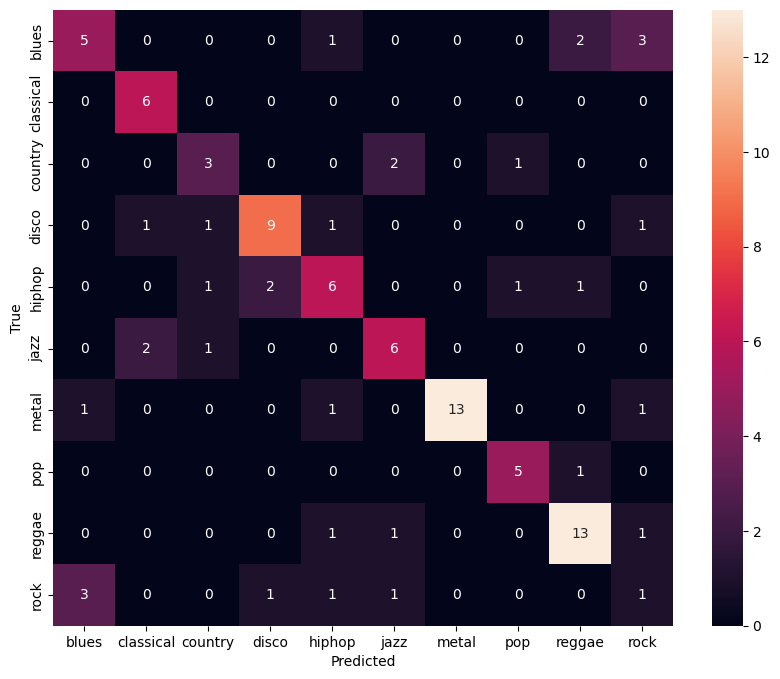

In [27]:
# Create confusion matrix
def get_confusion_matrix(model4, test_loader, num_classes):
    model4.eval()
    confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='multiclass')
    confusion_matrix.cuda()  
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model4(images)
            _, predicted = torch.max(outputs, 1)
            confusion_matrix.update(predicted, labels)

    return confusion_matrix.compute().cpu().numpy()

# Make sure put the right number in it
num_classes = len(dataset.classes)  
conf_matrix = get_confusion_matrix(model4, test_loader, num_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')

In [18]:
torch.cuda.empty_cache()

## Net 3 (Convolutional Network adding a Batch Normalisation Layer)

In [29]:
class ConvNetModified(nn.Module):
    def __init__(self, num_classes):
        super(ConvNetModified, self).__init__()
        # Conv1 + ReLU
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # + Batch Normalisation Layer
        self.relu1 = nn.ReLU()
        
        # Conv2 + ReLU
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # MaxPool1
        
        # Conv3 + ReLU
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        # Conv4 + ReLU
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # MaxPool2
        
        # Fully Connected1(out_features = 256) + ReLU
        self.fc1 = nn.Linear(256 * 45 * 45, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes) # Fully Connected2

    def forward(self, x):
        # Conv1 layer, Batch Normalisation, Activation Function
        x = self.conv1(x)
        x = self.bn1(x) 
        x = self.relu1(x)
        
        # Conv2 layer, Activation Function, MaxPool1 layer
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        
        # Conv3 layer, Activation Function
        x = self.conv3(x)
        x = self.relu3(x)
        
        # Conv4 layer, Activation function, MaxPool2 layer
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        
        # Flattening the feature map for Fully Connected layer
        x = x.view(x.size(0), -1)
        
        # Fully Connected1 layer, Activation function
        x = self.relu5(self.fc1(x))
        
        #  Fully Connected2 layer
        x = self.fc2(x)
        return x

### Epochs = 50 (Model 5) 

In [30]:
# model 5
model5 = ConvNetModified(10).cuda()

# Def Optimizer,Loss Function
# 0.0001 has significantly loss fluctuations, 0.00001 loss decrease too slow
# So 0.00005
optimizer = Adam(model5.parameters(), lr=0.00005)
loss_fn = nn.CrossEntropyLoss()
batch_size = 32

# Def accuracy
def get_accuracy(dataloader, model5):
    accuracy = MulticlassAccuracy(10).cuda()
    total = 0
    correct = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model5(imgs)
        # The second return value is the index of the max i.e., argmax
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        accuracy.update(outputs, labels)


    return (correct / total).item(), accuracy.compute().item()

In [14]:
# Training model for 50 epochs
epochs = 50
for epoch in range(epochs):
    model5.train()
    loop = tqdm(train_loader)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
    epoch_loss = 0
    for imgs, labels in loop:
        imgs, labels = imgs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model5(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss=0.9*epoch_loss+0.1*loss.item()
        loop.set_postfix(loss=epoch_loss)
    
# Caculate the Val Accuracy
    _,acc = get_accuracy(val_loader, model5)
    print(f"Loss: {epoch_loss:.4f},  Val Accuracy: {acc:.4f}")

Epoch [1/50]: 100%|██████████| 22/22 [00:04<00:00,  4.77it/s, loss=2.06]


Loss: 2.0553,  Val Accuracy: 0.1662


Epoch [2/50]: 100%|██████████| 22/22 [00:04<00:00,  4.88it/s, loss=1.84]


Loss: 1.8400,  Val Accuracy: 0.3062


Epoch [3/50]: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s, loss=1.66]


Loss: 1.6622,  Val Accuracy: 0.3586


Epoch [4/50]: 100%|██████████| 22/22 [00:04<00:00,  4.89it/s, loss=1.49]


Loss: 1.4904,  Val Accuracy: 0.3750


Epoch [5/50]: 100%|██████████| 22/22 [00:04<00:00,  4.83it/s, loss=1.34] 


Loss: 1.3432,  Val Accuracy: 0.4216


Epoch [6/50]: 100%|██████████| 22/22 [00:04<00:00,  4.88it/s, loss=1.25] 


Loss: 1.2468,  Val Accuracy: 0.4654


Epoch [7/50]: 100%|██████████| 22/22 [00:04<00:00,  4.87it/s, loss=1.09] 


Loss: 1.0896,  Val Accuracy: 0.4250


Epoch [8/50]: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s, loss=0.945]


Loss: 0.9452,  Val Accuracy: 0.5099


Epoch [9/50]: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s, loss=0.81] 


Loss: 0.8102,  Val Accuracy: 0.5757


Epoch [10/50]: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s, loss=0.665]


Loss: 0.6650,  Val Accuracy: 0.5385


Epoch [11/50]: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s, loss=0.584]


Loss: 0.5844,  Val Accuracy: 0.5702


Epoch [12/50]: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s, loss=0.53] 


Loss: 0.5299,  Val Accuracy: 0.5837


Epoch [13/50]: 100%|██████████| 22/22 [00:04<00:00,  4.83it/s, loss=0.419]


Loss: 0.4193,  Val Accuracy: 0.5952


Epoch [14/50]: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s, loss=0.338]


Loss: 0.3381,  Val Accuracy: 0.5934


Epoch [15/50]: 100%|██████████| 22/22 [00:04<00:00,  4.83it/s, loss=0.276]


Loss: 0.2762,  Val Accuracy: 0.6035


Epoch [16/50]: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s, loss=0.207]


Loss: 0.2072,  Val Accuracy: 0.5482


Epoch [17/50]: 100%|██████████| 22/22 [00:04<00:00,  4.82it/s, loss=0.219]


Loss: 0.2193,  Val Accuracy: 0.5722


Epoch [18/50]: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s, loss=0.227]


Loss: 0.2269,  Val Accuracy: 0.5546


Epoch [19/50]: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s, loss=0.145] 


Loss: 0.1450,  Val Accuracy: 0.5690


Epoch [20/50]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.109] 


Loss: 0.1085,  Val Accuracy: 0.5860


Epoch [21/50]: 100%|██████████| 22/22 [00:04<00:00,  4.71it/s, loss=0.0888]


Loss: 0.0888,  Val Accuracy: 0.5930


Epoch [22/50]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.0575]


Loss: 0.0575,  Val Accuracy: 0.5938


Epoch [23/50]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.043] 


Loss: 0.0430,  Val Accuracy: 0.5985


Epoch [24/50]: 100%|██████████| 22/22 [00:04<00:00,  4.72it/s, loss=0.0404]


Loss: 0.0404,  Val Accuracy: 0.5725


Epoch [25/50]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.039] 


Loss: 0.0390,  Val Accuracy: 0.5727


Epoch [26/50]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.0293]


Loss: 0.0293,  Val Accuracy: 0.5632


Epoch [27/50]: 100%|██████████| 22/22 [00:04<00:00,  4.70it/s, loss=0.0251]


Loss: 0.0251,  Val Accuracy: 0.5798


Epoch [28/50]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.0257]


Loss: 0.0257,  Val Accuracy: 0.5602


Epoch [29/50]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.0276]


Loss: 0.0276,  Val Accuracy: 0.5733


Epoch [30/50]: 100%|██████████| 22/22 [00:04<00:00,  4.69it/s, loss=0.0299]


Loss: 0.0299,  Val Accuracy: 0.6178


Epoch [31/50]: 100%|██████████| 22/22 [00:04<00:00,  4.77it/s, loss=0.0536]


Loss: 0.0536,  Val Accuracy: 0.5524


Epoch [32/50]: 100%|██████████| 22/22 [00:04<00:00,  4.71it/s, loss=0.0505]


Loss: 0.0505,  Val Accuracy: 0.5766


Epoch [33/50]: 100%|██████████| 22/22 [00:04<00:00,  4.67it/s, loss=0.0236]


Loss: 0.0236,  Val Accuracy: 0.5598


Epoch [34/50]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.0172]


Loss: 0.0172,  Val Accuracy: 0.5758


Epoch [35/50]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.0243] 


Loss: 0.0243,  Val Accuracy: 0.6036


Epoch [36/50]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.0295] 


Loss: 0.0295,  Val Accuracy: 0.6221


Epoch [37/50]: 100%|██████████| 22/22 [00:04<00:00,  4.66it/s, loss=0.02]   


Loss: 0.0200,  Val Accuracy: 0.6173


Epoch [38/50]: 100%|██████████| 22/22 [00:04<00:00,  4.66it/s, loss=0.019] 


Loss: 0.0190,  Val Accuracy: 0.6106


Epoch [39/50]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.0107]


Loss: 0.0107,  Val Accuracy: 0.6195


Epoch [40/50]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.01]   


Loss: 0.0100,  Val Accuracy: 0.5921


Epoch [41/50]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.0205] 


Loss: 0.0205,  Val Accuracy: 0.5681


Epoch [42/50]: 100%|██████████| 22/22 [00:04<00:00,  4.71it/s, loss=0.0108] 


Loss: 0.0108,  Val Accuracy: 0.6085


Epoch [43/50]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.0135] 


Loss: 0.0135,  Val Accuracy: 0.5958


Epoch [44/50]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.0163] 


Loss: 0.0163,  Val Accuracy: 0.6031


Epoch [45/50]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.0118] 


Loss: 0.0118,  Val Accuracy: 0.6166


Epoch [46/50]: 100%|██████████| 22/22 [00:04<00:00,  4.77it/s, loss=0.0117] 


Loss: 0.0117,  Val Accuracy: 0.5715


Epoch [47/50]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.0115] 


Loss: 0.0115,  Val Accuracy: 0.5639


Epoch [48/50]: 100%|██████████| 22/22 [00:04<00:00,  4.72it/s, loss=0.0168] 


Loss: 0.0168,  Val Accuracy: 0.5830


Epoch [49/50]: 100%|██████████| 22/22 [00:04<00:00,  4.77it/s, loss=0.0254] 


Loss: 0.0254,  Val Accuracy: 0.5670


Epoch [50/50]: 100%|██████████| 22/22 [00:04<00:00,  4.72it/s, loss=0.00944]


Loss: 0.0094,  Val Accuracy: 0.6016


In [15]:
def test_model(model5, test_loader):
    model5.eval()  # Evaluate mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model5(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy

test_accuracy = test_model(model5, test_loader)

Test Accuracy: 0.7030


Text(95.72222222222221, 0.5, 'True')

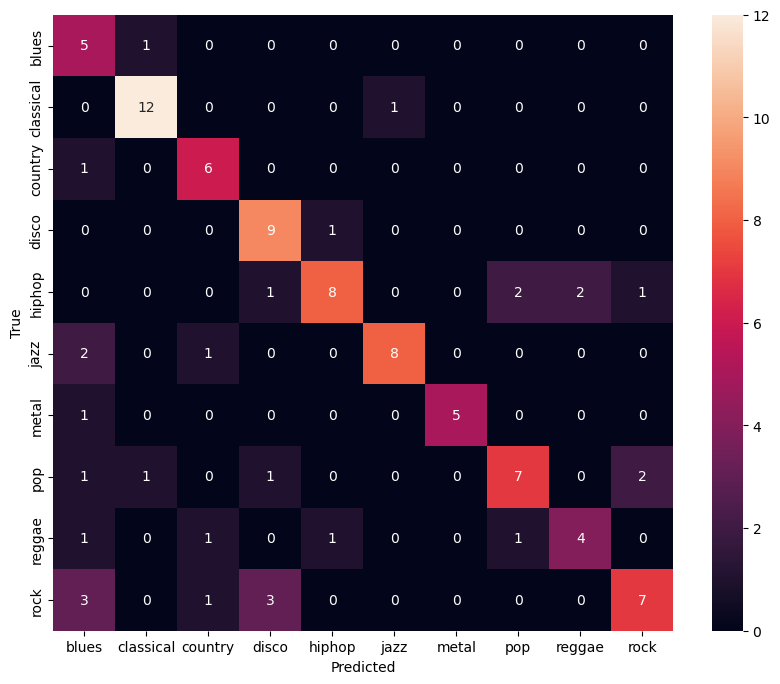

In [16]:
# Create confusion matrix
def get_confusion_matrix(model5, test_loader, num_classes):
    model5.eval()
    confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='multiclass')
    confusion_matrix.cuda()  
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model5(images)
            _, predicted = torch.max(outputs, 1)
            confusion_matrix.update(predicted, labels)

    return confusion_matrix.compute().cpu().numpy()

# Make sure put the right number in it
num_classes = len(dataset.classes)
conf_matrix = get_confusion_matrix(model5, test_loader, num_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')

### Epochs = 100 (Model 6)

In [21]:
# model 6
model6 = ConvNetModified(10).cuda()

# Def Optimizer,Loss Function
# 0.0001 has significantly loss fluctuations, 0.00001 loss decrease too slow
# So 0.00005
optimizer = Adam(model6.parameters(), lr=0.00005)
loss_fn = nn.CrossEntropyLoss()
batch_size = 32

# Def accuracy
def get_accuracy(dataloader, model6):
    accuracy = MulticlassAccuracy(10).cuda()
    total = 0
    correct = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model6(imgs)
        # The second return value is the index of the max i.e., argmax
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        accuracy.update(outputs, labels)


    return (correct / total).item(), accuracy.compute().item()

In [22]:
# Training model for 100 epochs
epochs = 100
for epoch in range(epochs):
    model6.train()
    loop = tqdm(train_loader)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
    epoch_loss = 0
    for imgs, labels in loop:
        imgs, labels = imgs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model6(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss=0.9*epoch_loss+0.1*loss.item()
        loop.set_postfix(loss=epoch_loss)
    
# Caculate the Val accuracy
    _,acc = get_accuracy(val_loader, model6)
    print(f"Loss: {epoch_loss:.4f},  Val Accuracy: {acc:.4f}")

Epoch [1/100]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=2.07]


Loss: 2.0666,  Val Accuracy: 0.2096


Epoch [2/100]: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s, loss=1.91]


Loss: 1.9063,  Val Accuracy: 0.1660


Epoch [3/100]: 100%|██████████| 22/22 [00:04<00:00,  4.92it/s, loss=1.69]


Loss: 1.6859,  Val Accuracy: 0.3729


Epoch [4/100]: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s, loss=1.47]


Loss: 1.4704,  Val Accuracy: 0.4177


Epoch [5/100]: 100%|██████████| 22/22 [00:04<00:00,  4.88it/s, loss=1.26] 


Loss: 1.2554,  Val Accuracy: 0.4862


Epoch [6/100]: 100%|██████████| 22/22 [00:04<00:00,  4.87it/s, loss=1.06] 


Loss: 1.0629,  Val Accuracy: 0.4814


Epoch [7/100]: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s, loss=0.958]


Loss: 0.9575,  Val Accuracy: 0.5448


Epoch [8/100]: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s, loss=0.889]


Loss: 0.8894,  Val Accuracy: 0.5605


Epoch [9/100]: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s, loss=0.689]


Loss: 0.6891,  Val Accuracy: 0.5914


Epoch [10/100]: 100%|██████████| 22/22 [00:04<00:00,  4.82it/s, loss=0.624]


Loss: 0.6239,  Val Accuracy: 0.5677


Epoch [11/100]: 100%|██████████| 22/22 [00:04<00:00,  4.83it/s, loss=0.525]


Loss: 0.5250,  Val Accuracy: 0.5906


Epoch [12/100]: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s, loss=0.442]


Loss: 0.4419,  Val Accuracy: 0.5277


Epoch [13/100]: 100%|██████████| 22/22 [00:04<00:00,  4.83it/s, loss=0.323]


Loss: 0.3232,  Val Accuracy: 0.6482


Epoch [14/100]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.286]


Loss: 0.2863,  Val Accuracy: 0.5947


Epoch [15/100]: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s, loss=0.22] 


Loss: 0.2198,  Val Accuracy: 0.6112


Epoch [16/100]: 100%|██████████| 22/22 [00:04<00:00,  4.83it/s, loss=0.156]


Loss: 0.1562,  Val Accuracy: 0.5895


Epoch [17/100]: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s, loss=0.152] 


Loss: 0.1516,  Val Accuracy: 0.6049


Epoch [18/100]: 100%|██████████| 22/22 [00:04<00:00,  4.82it/s, loss=0.118] 


Loss: 0.1176,  Val Accuracy: 0.5947


Epoch [19/100]: 100%|██████████| 22/22 [00:04<00:00,  4.83it/s, loss=0.111] 


Loss: 0.1110,  Val Accuracy: 0.6345


Epoch [20/100]: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s, loss=0.0921]


Loss: 0.0921,  Val Accuracy: 0.6464


Epoch [21/100]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.0574]


Loss: 0.0574,  Val Accuracy: 0.6403


Epoch [22/100]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.0491]


Loss: 0.0491,  Val Accuracy: 0.6518


Epoch [23/100]: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s, loss=0.0571]


Loss: 0.0571,  Val Accuracy: 0.5955


Epoch [24/100]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.079] 


Loss: 0.0790,  Val Accuracy: 0.6114


Epoch [25/100]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.0304]


Loss: 0.0304,  Val Accuracy: 0.5797


Epoch [26/100]: 100%|██████████| 22/22 [00:04<00:00,  4.77it/s, loss=0.0267]


Loss: 0.0267,  Val Accuracy: 0.6276


Epoch [27/100]: 100%|██████████| 22/22 [00:04<00:00,  4.70it/s, loss=0.046] 


Loss: 0.0460,  Val Accuracy: 0.6484


Epoch [28/100]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.0408]


Loss: 0.0408,  Val Accuracy: 0.6334


Epoch [29/100]: 100%|██████████| 22/22 [00:04<00:00,  4.77it/s, loss=0.0296]


Loss: 0.0296,  Val Accuracy: 0.6032


Epoch [30/100]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.119]  


Loss: 0.1190,  Val Accuracy: 0.5501


Epoch [31/100]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.053] 


Loss: 0.0530,  Val Accuracy: 0.6202


Epoch [32/100]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.0264]


Loss: 0.0264,  Val Accuracy: 0.6249


Epoch [33/100]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.0202] 


Loss: 0.0202,  Val Accuracy: 0.6372


Epoch [34/100]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.0285] 


Loss: 0.0285,  Val Accuracy: 0.6357


Epoch [35/100]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.0234] 


Loss: 0.0234,  Val Accuracy: 0.6461


Epoch [36/100]: 100%|██████████| 22/22 [00:04<00:00,  4.70it/s, loss=0.026] 


Loss: 0.0260,  Val Accuracy: 0.6469


Epoch [37/100]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.0374]


Loss: 0.0374,  Val Accuracy: 0.6541


Epoch [38/100]: 100%|██████████| 22/22 [00:04<00:00,  4.67it/s, loss=0.0184] 


Loss: 0.0184,  Val Accuracy: 0.6405


Epoch [39/100]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.0228] 


Loss: 0.0228,  Val Accuracy: 0.6545


Epoch [40/100]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.0162] 


Loss: 0.0162,  Val Accuracy: 0.6241


Epoch [41/100]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.0214] 


Loss: 0.0214,  Val Accuracy: 0.6561


Epoch [42/100]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.0329]


Loss: 0.0329,  Val Accuracy: 0.6464


Epoch [43/100]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.00776]


Loss: 0.0078,  Val Accuracy: 0.6509


Epoch [44/100]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.0139] 


Loss: 0.0139,  Val Accuracy: 0.6177


Epoch [45/100]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.00807]


Loss: 0.0081,  Val Accuracy: 0.6389


Epoch [46/100]: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s, loss=0.0162] 


Loss: 0.0162,  Val Accuracy: 0.6383


Epoch [47/100]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.012]  


Loss: 0.0120,  Val Accuracy: 0.6461


Epoch [48/100]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.022]  


Loss: 0.0220,  Val Accuracy: 0.6233


Epoch [49/100]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.00829]


Loss: 0.0083,  Val Accuracy: 0.6544


Epoch [50/100]: 100%|██████████| 22/22 [00:04<00:00,  4.71it/s, loss=0.0129] 


Loss: 0.0129,  Val Accuracy: 0.6368


Epoch [51/100]: 100%|██████████| 22/22 [00:04<00:00,  4.70it/s, loss=0.0075] 


Loss: 0.0075,  Val Accuracy: 0.6366


Epoch [52/100]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.0107] 


Loss: 0.0107,  Val Accuracy: 0.6517


Epoch [53/100]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.0183] 


Loss: 0.0183,  Val Accuracy: 0.6431


Epoch [54/100]: 100%|██████████| 22/22 [00:04<00:00,  4.71it/s, loss=0.0167] 


Loss: 0.0167,  Val Accuracy: 0.6295


Epoch [55/100]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.0136] 


Loss: 0.0136,  Val Accuracy: 0.6367


Epoch [56/100]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.00864]


Loss: 0.0086,  Val Accuracy: 0.6680


Epoch [57/100]: 100%|██████████| 22/22 [00:04<00:00,  4.68it/s, loss=0.0156] 


Loss: 0.0156,  Val Accuracy: 0.6163


Epoch [58/100]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.00926]


Loss: 0.0093,  Val Accuracy: 0.6220


Epoch [59/100]: 100%|██████████| 22/22 [00:04<00:00,  4.86it/s, loss=0.00777]


Loss: 0.0078,  Val Accuracy: 0.5910


Epoch [60/100]: 100%|██████████| 22/22 [00:04<00:00,  4.81it/s, loss=0.0457] 


Loss: 0.0457,  Val Accuracy: 0.6423


Epoch [61/100]: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s, loss=0.00415]


Loss: 0.0041,  Val Accuracy: 0.6425


Epoch [62/100]: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s, loss=0.00561]


Loss: 0.0056,  Val Accuracy: 0.6468


Epoch [63/100]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.0128] 


Loss: 0.0128,  Val Accuracy: 0.5945


Epoch [64/100]: 100%|██████████| 22/22 [00:04<00:00,  4.86it/s, loss=0.00731]


Loss: 0.0073,  Val Accuracy: 0.6364


Epoch [65/100]: 100%|██████████| 22/22 [00:04<00:00,  4.85it/s, loss=0.0234] 


Loss: 0.0234,  Val Accuracy: 0.6263


Epoch [66/100]: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s, loss=0.0255] 


Loss: 0.0255,  Val Accuracy: 0.6656


Epoch [67/100]: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s, loss=0.00942]


Loss: 0.0094,  Val Accuracy: 0.6626


Epoch [68/100]: 100%|██████████| 22/22 [00:04<00:00,  4.86it/s, loss=0.0238] 


Loss: 0.0238,  Val Accuracy: 0.6351


Epoch [69/100]: 100%|██████████| 22/22 [00:04<00:00,  4.67it/s, loss=0.00671]


Loss: 0.0067,  Val Accuracy: 0.6621


Epoch [70/100]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.0344] 


Loss: 0.0344,  Val Accuracy: 0.6282


Epoch [71/100]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.0374] 


Loss: 0.0374,  Val Accuracy: 0.6347


Epoch [72/100]: 100%|██████████| 22/22 [00:04<00:00,  4.69it/s, loss=0.00407]


Loss: 0.0041,  Val Accuracy: 0.6292


Epoch [73/100]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.036]  


Loss: 0.0360,  Val Accuracy: 0.6577


Epoch [74/100]: 100%|██████████| 22/22 [00:04<00:00,  4.76it/s, loss=0.00223]


Loss: 0.0022,  Val Accuracy: 0.6454


Epoch [75/100]: 100%|██████████| 22/22 [00:04<00:00,  4.68it/s, loss=0.00437]


Loss: 0.0044,  Val Accuracy: 0.6696


Epoch [76/100]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.00528]


Loss: 0.0053,  Val Accuracy: 0.6613


Epoch [77/100]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.00811]


Loss: 0.0081,  Val Accuracy: 0.6710


Epoch [78/100]: 100%|██████████| 22/22 [00:04<00:00,  4.71it/s, loss=0.00627]


Loss: 0.0063,  Val Accuracy: 0.6634


Epoch [79/100]: 100%|██████████| 22/22 [00:04<00:00,  4.80it/s, loss=0.00332]


Loss: 0.0033,  Val Accuracy: 0.6693


Epoch [80/100]: 100%|██████████| 22/22 [00:04<00:00,  4.77it/s, loss=0.0071] 


Loss: 0.0071,  Val Accuracy: 0.6545


Epoch [81/100]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.00871] 


Loss: 0.0087,  Val Accuracy: 0.6467


Epoch [82/100]: 100%|██████████| 22/22 [00:04<00:00,  4.78it/s, loss=0.0169] 


Loss: 0.0169,  Val Accuracy: 0.6368


Epoch [83/100]: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s, loss=0.0078] 


Loss: 0.0078,  Val Accuracy: 0.6222


Epoch [84/100]: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s, loss=0.0152] 


Loss: 0.0152,  Val Accuracy: 0.6423


Epoch [85/100]: 100%|██████████| 22/22 [00:04<00:00,  4.79it/s, loss=0.0169] 


Loss: 0.0169,  Val Accuracy: 0.6370


Epoch [86/100]: 100%|██████████| 22/22 [00:04<00:00,  4.77it/s, loss=0.0151] 


Loss: 0.0151,  Val Accuracy: 0.6640


Epoch [87/100]: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s, loss=0.00767]


Loss: 0.0077,  Val Accuracy: 0.6655


Epoch [88/100]: 100%|██████████| 22/22 [00:04<00:00,  4.51it/s, loss=0.014]  


Loss: 0.0140,  Val Accuracy: 0.6490


Epoch [89/100]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.00259]


Loss: 0.0026,  Val Accuracy: 0.6634


Epoch [90/100]: 100%|██████████| 22/22 [00:04<00:00,  4.64it/s, loss=0.0226] 


Loss: 0.0226,  Val Accuracy: 0.6526


Epoch [91/100]: 100%|██████████| 22/22 [00:04<00:00,  4.62it/s, loss=0.0136] 


Loss: 0.0136,  Val Accuracy: 0.6434


Epoch [92/100]: 100%|██████████| 22/22 [00:04<00:00,  4.56it/s, loss=0.00698]


Loss: 0.0070,  Val Accuracy: 0.6582


Epoch [93/100]: 100%|██████████| 22/22 [00:04<00:00,  4.70it/s, loss=0.00632]


Loss: 0.0063,  Val Accuracy: 0.6736


Epoch [94/100]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.0148] 


Loss: 0.0148,  Val Accuracy: 0.6506


Epoch [95/100]: 100%|██████████| 22/22 [00:04<00:00,  4.75it/s, loss=0.00516]


Loss: 0.0052,  Val Accuracy: 0.6623


Epoch [96/100]: 100%|██████████| 22/22 [00:04<00:00,  4.66it/s, loss=0.00372]


Loss: 0.0037,  Val Accuracy: 0.6659


Epoch [97/100]: 100%|██████████| 22/22 [00:04<00:00,  4.83it/s, loss=0.00623] 


Loss: 0.0062,  Val Accuracy: 0.6601


Epoch [98/100]: 100%|██████████| 22/22 [00:04<00:00,  4.74it/s, loss=0.00721]


Loss: 0.0072,  Val Accuracy: 0.6667


Epoch [99/100]: 100%|██████████| 22/22 [00:04<00:00,  4.61it/s, loss=0.0143] 


Loss: 0.0143,  Val Accuracy: 0.6501


Epoch [100/100]: 100%|██████████| 22/22 [00:04<00:00,  4.67it/s, loss=0.00228]


Loss: 0.0023,  Val Accuracy: 0.6440


In [23]:
def test_model(model6, test_loader):
    model6.eval()  # Evulate mode
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model6(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy

test_accuracy = test_model(model6, test_loader)

Test Accuracy: 0.7129


Text(95.72222222222221, 0.5, 'True')

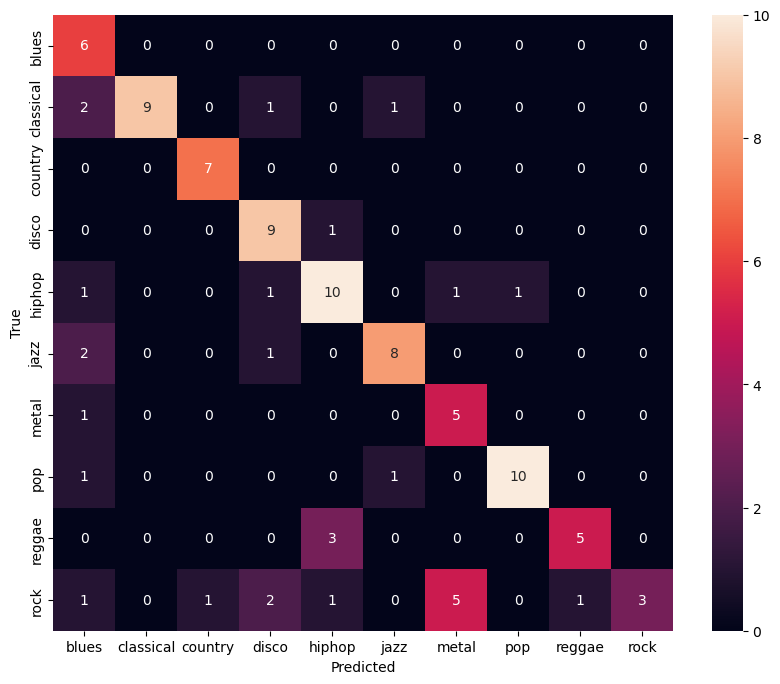

In [24]:
# Create confusion matrix
def get_confusion_matrix(model6, test_loader, num_classes):
    model6.eval()
    confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='multiclass')
    confusion_matrix.cuda() 
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model6(images)
            _, predicted = torch.max(outputs, 1)
            confusion_matrix.update(predicted, labels)

    return confusion_matrix.compute().cpu().numpy()

# Make sure put the right number in it
num_classes = len(dataset.classes) 
conf_matrix = get_confusion_matrix(model6, test_loader, num_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')

In [31]:
torch.cuda.empty_cache()

## Net 4 (Same Architecture as Net 3 but use RMSprop as optimizer)

In [5]:
# Import RMSProp
from torch.optim import RMSprop

### Epochs = 50 (Model 7)

In [33]:
# model 7
model7 = ConvNetModified(10).cuda()

# Def Optimizer,Loss Function
# 0.00005 has significantly loss fluctuations
# So 0.00001
optimizer = RMSprop(model7.parameters(), lr=0.00001)
loss_fn = nn.CrossEntropyLoss()
batch_size = 32

# Def accuracy
def get_accuracy(dataloader, model7):
    accuracy = MulticlassAccuracy(10).cuda()
    total = 0
    correct = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model7(imgs)
        # The second return value is the index of the max i.e., argmax
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        accuracy.update(outputs, labels)


    return (correct / total).item(), accuracy.compute().item()


In [34]:
# Training model for 50 epochs
epochs = 50
for epoch in range(epochs):
    model7.train()
    loop = tqdm(train_loader)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
    epoch_loss = 0
    for imgs, labels in loop:
        imgs, labels = imgs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model7(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss=0.9*epoch_loss+0.1*loss.item()
        loop.set_postfix(loss=epoch_loss)
    
# Caculate the Val accuracy
    _,acc = get_accuracy(val_loader, model7)
    print(f"Loss: {epoch_loss:.4f},  Val Accuracy: {acc:.4f}")

Epoch [1/50]: 100%|██████████| 22/22 [00:04<00:00,  4.81it/s, loss=2.07]


Loss: 2.0741,  Val Accuracy: 0.2327


Epoch [2/50]: 100%|██████████| 22/22 [00:04<00:00,  4.95it/s, loss=1.98]


Loss: 1.9769,  Val Accuracy: 0.2361


Epoch [3/50]: 100%|██████████| 22/22 [00:04<00:00,  5.00it/s, loss=1.84]


Loss: 1.8417,  Val Accuracy: 0.3218


Epoch [4/50]: 100%|██████████| 22/22 [00:04<00:00,  4.93it/s, loss=1.7] 


Loss: 1.7013,  Val Accuracy: 0.3003


Epoch [5/50]: 100%|██████████| 22/22 [00:04<00:00,  4.94it/s, loss=1.63]


Loss: 1.6300,  Val Accuracy: 0.3764


Epoch [6/50]: 100%|██████████| 22/22 [00:04<00:00,  4.67it/s, loss=1.5] 


Loss: 1.4963,  Val Accuracy: 0.3884


Epoch [7/50]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=1.47]


Loss: 1.4664,  Val Accuracy: 0.4046


Epoch [8/50]: 100%|██████████| 22/22 [00:04<00:00,  4.64it/s, loss=1.37]


Loss: 1.3733,  Val Accuracy: 0.4267


Epoch [9/50]: 100%|██████████| 22/22 [00:04<00:00,  4.65it/s, loss=1.28] 


Loss: 1.2826,  Val Accuracy: 0.4445


Epoch [10/50]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=1.24] 


Loss: 1.2374,  Val Accuracy: 0.4391


Epoch [11/50]: 100%|██████████| 22/22 [00:04<00:00,  4.67it/s, loss=1.21] 


Loss: 1.2125,  Val Accuracy: 0.4243


Epoch [12/50]: 100%|██████████| 22/22 [00:04<00:00,  4.64it/s, loss=1.16] 


Loss: 1.1578,  Val Accuracy: 0.4731


Epoch [13/50]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=1.13] 


Loss: 1.1263,  Val Accuracy: 0.4734


Epoch [14/50]: 100%|██████████| 22/22 [00:04<00:00,  4.64it/s, loss=1.14] 


Loss: 1.1419,  Val Accuracy: 0.4207


Epoch [15/50]: 100%|██████████| 22/22 [00:04<00:00,  4.67it/s, loss=1.06] 


Loss: 1.0585,  Val Accuracy: 0.5205


Epoch [16/50]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=1.07] 


Loss: 1.0666,  Val Accuracy: 0.5164


Epoch [17/50]: 100%|██████████| 22/22 [00:04<00:00,  4.63it/s, loss=0.945]


Loss: 0.9447,  Val Accuracy: 0.5169


Epoch [18/50]: 100%|██████████| 22/22 [00:04<00:00,  4.51it/s, loss=0.972]


Loss: 0.9716,  Val Accuracy: 0.4968


Epoch [19/50]: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s, loss=0.907]


Loss: 0.9066,  Val Accuracy: 0.5316


Epoch [20/50]: 100%|██████████| 22/22 [00:04<00:00,  4.66it/s, loss=0.876]


Loss: 0.8759,  Val Accuracy: 0.5136


Epoch [21/50]: 100%|██████████| 22/22 [00:04<00:00,  4.61it/s, loss=0.853]


Loss: 0.8530,  Val Accuracy: 0.5390


Epoch [22/50]: 100%|██████████| 22/22 [00:04<00:00,  4.58it/s, loss=0.88] 


Loss: 0.8796,  Val Accuracy: 0.4757


Epoch [23/50]: 100%|██████████| 22/22 [00:04<00:00,  4.60it/s, loss=0.822]


Loss: 0.8222,  Val Accuracy: 0.5415


Epoch [24/50]: 100%|██████████| 22/22 [00:04<00:00,  4.54it/s, loss=0.831]


Loss: 0.8311,  Val Accuracy: 0.5540


Epoch [25/50]: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s, loss=0.789]


Loss: 0.7893,  Val Accuracy: 0.5313


Epoch [26/50]: 100%|██████████| 22/22 [00:04<00:00,  4.63it/s, loss=0.768]


Loss: 0.7683,  Val Accuracy: 0.5674


Epoch [27/50]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.724]


Loss: 0.7244,  Val Accuracy: 0.5758


Epoch [28/50]: 100%|██████████| 22/22 [00:04<00:00,  4.63it/s, loss=0.752]


Loss: 0.7520,  Val Accuracy: 0.5667


Epoch [29/50]: 100%|██████████| 22/22 [00:04<00:00,  4.62it/s, loss=0.682]


Loss: 0.6822,  Val Accuracy: 0.5356


Epoch [30/50]: 100%|██████████| 22/22 [00:04<00:00,  4.56it/s, loss=0.627]


Loss: 0.6270,  Val Accuracy: 0.5509


Epoch [31/50]: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s, loss=0.672]


Loss: 0.6716,  Val Accuracy: 0.5008


Epoch [32/50]: 100%|██████████| 22/22 [00:04<00:00,  4.58it/s, loss=0.64] 


Loss: 0.6401,  Val Accuracy: 0.5874


Epoch [33/50]: 100%|██████████| 22/22 [00:04<00:00,  4.52it/s, loss=0.587]


Loss: 0.5870,  Val Accuracy: 0.5520


Epoch [34/50]: 100%|██████████| 22/22 [00:04<00:00,  4.61it/s, loss=0.614]


Loss: 0.6138,  Val Accuracy: 0.5754


Epoch [35/50]: 100%|██████████| 22/22 [00:04<00:00,  4.62it/s, loss=0.59] 


Loss: 0.5903,  Val Accuracy: 0.5450


Epoch [36/50]: 100%|██████████| 22/22 [00:04<00:00,  4.51it/s, loss=0.562]


Loss: 0.5624,  Val Accuracy: 0.5688


Epoch [37/50]: 100%|██████████| 22/22 [00:04<00:00,  4.62it/s, loss=0.559]


Loss: 0.5588,  Val Accuracy: 0.5130


Epoch [38/50]: 100%|██████████| 22/22 [00:04<00:00,  4.62it/s, loss=0.533]


Loss: 0.5328,  Val Accuracy: 0.5239


Epoch [39/50]: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s, loss=0.506]


Loss: 0.5058,  Val Accuracy: 0.5750


Epoch [40/50]: 100%|██████████| 22/22 [00:04<00:00,  4.58it/s, loss=0.483]


Loss: 0.4826,  Val Accuracy: 0.5617


Epoch [41/50]: 100%|██████████| 22/22 [00:04<00:00,  4.57it/s, loss=0.441]


Loss: 0.4405,  Val Accuracy: 0.5541


Epoch [42/50]: 100%|██████████| 22/22 [00:04<00:00,  4.55it/s, loss=0.484]


Loss: 0.4841,  Val Accuracy: 0.5460


Epoch [43/50]: 100%|██████████| 22/22 [00:04<00:00,  4.59it/s, loss=0.434]


Loss: 0.4337,  Val Accuracy: 0.5543


Epoch [44/50]: 100%|██████████| 22/22 [00:04<00:00,  4.60it/s, loss=0.445]


Loss: 0.4448,  Val Accuracy: 0.5780


Epoch [45/50]: 100%|██████████| 22/22 [00:04<00:00,  4.47it/s, loss=0.436]


Loss: 0.4364,  Val Accuracy: 0.5868


Epoch [46/50]: 100%|██████████| 22/22 [00:04<00:00,  4.47it/s, loss=0.388]


Loss: 0.3878,  Val Accuracy: 0.5973


Epoch [47/50]: 100%|██████████| 22/22 [00:05<00:00,  4.26it/s, loss=0.425]


Loss: 0.4247,  Val Accuracy: 0.5567


Epoch [48/50]: 100%|██████████| 22/22 [00:04<00:00,  4.44it/s, loss=0.374]


Loss: 0.3740,  Val Accuracy: 0.5779


Epoch [49/50]: 100%|██████████| 22/22 [00:04<00:00,  4.47it/s, loss=0.339]


Loss: 0.3390,  Val Accuracy: 0.5924


Epoch [50/50]: 100%|██████████| 22/22 [00:05<00:00,  4.36it/s, loss=0.332]


Loss: 0.3319,  Val Accuracy: 0.5926


In [35]:
def test_model(model7, test_loader):
    model7.eval()  # Evulate mode
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model7(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy

test_accuracy = test_model(model7, test_loader)

Test Accuracy: 0.6535


Text(95.72222222222221, 0.5, 'True')

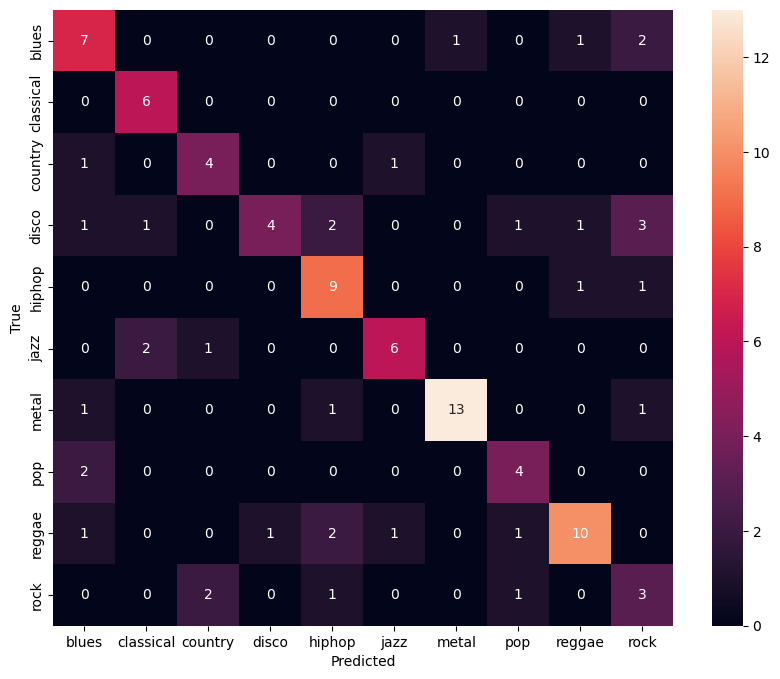

In [36]:
# Create confusion matrix
def get_confusion_matrix(model7, test_loader, num_classes):
    model7.eval()
    confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='multiclass')
    confusion_matrix.cuda() 
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model7(images)
            _, predicted = torch.max(outputs, 1)
            confusion_matrix.update(predicted, labels)

    return confusion_matrix.compute().cpu().numpy()

# Make sure put the right number in it
num_classes = len(dataset.classes)  
conf_matrix = get_confusion_matrix(model7, test_loader, num_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')

### Epochs = 100 (Model 8)

In [37]:
# model 8
model8 = ConvNetModified(10).cuda()

# Def Optimizer,Loss Function
# 0.00005 has significantly loss fluctuations
# So 0.00001
optimizer = RMSprop(model8.parameters(), lr=0.00001)
loss_fn = nn.CrossEntropyLoss()
batch_size = 64

# Def accuracy
def get_accuracy(dataloader, model8):
    accuracy = MulticlassAccuracy(10).cuda()
    total = 0
    correct = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.cuda(), labels.cuda()
        outputs = model8(imgs)
        # The second return value is the index of the max i.e., argmax
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        accuracy.update(outputs, labels)


    return (correct / total).item(), accuracy.compute().item()


In [38]:
# Training model for 50 epochs
epochs = 100
for epoch in range(epochs):
    model8.train()
    loop = tqdm(train_loader)
    loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
    epoch_loss = 0
    for imgs, labels in loop:
        imgs, labels = imgs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model8(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss=0.9*epoch_loss+0.1*loss.item()
        loop.set_postfix(loss=epoch_loss)
    
# Caculate the Val accuracy
    _,acc = get_accuracy(val_loader, model8)
    print(f"Loss: {epoch_loss:.4f},  Val Accuracy: {acc:.4f}")

Epoch [1/100]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=2.04]


Loss: 2.0447,  Val Accuracy: 0.2468


Epoch [2/100]: 100%|██████████| 22/22 [00:05<00:00,  3.80it/s, loss=1.87]


Loss: 1.8718,  Val Accuracy: 0.2399


Epoch [3/100]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=1.78]


Loss: 1.7776,  Val Accuracy: 0.3105


Epoch [4/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=1.7] 


Loss: 1.6958,  Val Accuracy: 0.4250


Epoch [5/100]: 100%|██████████| 22/22 [00:05<00:00,  3.74it/s, loss=1.61]


Loss: 1.6127,  Val Accuracy: 0.3745


Epoch [6/100]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=1.56]


Loss: 1.5601,  Val Accuracy: 0.3834


Epoch [7/100]: 100%|██████████| 22/22 [00:05<00:00,  3.80it/s, loss=1.52]


Loss: 1.5176,  Val Accuracy: 0.3875


Epoch [8/100]: 100%|██████████| 22/22 [00:05<00:00,  3.89it/s, loss=1.44]


Loss: 1.4394,  Val Accuracy: 0.4614


Epoch [9/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=1.37]


Loss: 1.3677,  Val Accuracy: 0.4422


Epoch [10/100]: 100%|██████████| 22/22 [00:05<00:00,  3.89it/s, loss=1.33] 


Loss: 1.3324,  Val Accuracy: 0.4399


Epoch [11/100]: 100%|██████████| 22/22 [00:05<00:00,  3.88it/s, loss=1.26] 


Loss: 1.2649,  Val Accuracy: 0.5093


Epoch [12/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=1.23] 


Loss: 1.2252,  Val Accuracy: 0.5426


Epoch [13/100]: 100%|██████████| 22/22 [00:05<00:00,  3.77it/s, loss=1.18] 


Loss: 1.1815,  Val Accuracy: 0.4707


Epoch [14/100]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=1.11] 


Loss: 1.1144,  Val Accuracy: 0.4794


Epoch [15/100]: 100%|██████████| 22/22 [00:05<00:00,  3.76it/s, loss=1.04] 


Loss: 1.0425,  Val Accuracy: 0.5021


Epoch [16/100]: 100%|██████████| 22/22 [00:05<00:00,  3.68it/s, loss=1.06] 


Loss: 1.0592,  Val Accuracy: 0.5057


Epoch [17/100]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=0.99] 


Loss: 0.9903,  Val Accuracy: 0.5188


Epoch [18/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=0.953]


Loss: 0.9527,  Val Accuracy: 0.5391


Epoch [19/100]: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s, loss=0.938]


Loss: 0.9381,  Val Accuracy: 0.5792


Epoch [20/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.901]


Loss: 0.9014,  Val Accuracy: 0.5666


Epoch [21/100]: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s, loss=0.857]


Loss: 0.8574,  Val Accuracy: 0.5480


Epoch [22/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=0.875]


Loss: 0.8752,  Val Accuracy: 0.5880


Epoch [23/100]: 100%|██████████| 22/22 [00:05<00:00,  3.90it/s, loss=0.813]


Loss: 0.8132,  Val Accuracy: 0.5579


Epoch [24/100]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=0.771]


Loss: 0.7709,  Val Accuracy: 0.5016


Epoch [25/100]: 100%|██████████| 22/22 [00:05<00:00,  3.88it/s, loss=0.808]


Loss: 0.8078,  Val Accuracy: 0.5682


Epoch [26/100]: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s, loss=0.723]


Loss: 0.7230,  Val Accuracy: 0.5686


Epoch [27/100]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=0.736]


Loss: 0.7362,  Val Accuracy: 0.4822


Epoch [28/100]: 100%|██████████| 22/22 [00:05<00:00,  3.87it/s, loss=0.73] 


Loss: 0.7302,  Val Accuracy: 0.5588


Epoch [29/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=0.739]


Loss: 0.7393,  Val Accuracy: 0.4763


Epoch [30/100]: 100%|██████████| 22/22 [00:05<00:00,  3.89it/s, loss=0.628]


Loss: 0.6280,  Val Accuracy: 0.5460


Epoch [31/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.658]


Loss: 0.6585,  Val Accuracy: 0.5955


Epoch [32/100]: 100%|██████████| 22/22 [00:05<00:00,  3.90it/s, loss=0.615]


Loss: 0.6146,  Val Accuracy: 0.5929


Epoch [33/100]: 100%|██████████| 22/22 [00:06<00:00,  3.66it/s, loss=0.605]


Loss: 0.6055,  Val Accuracy: 0.5685


Epoch [34/100]: 100%|██████████| 22/22 [00:05<00:00,  3.89it/s, loss=0.552]


Loss: 0.5519,  Val Accuracy: 0.5768


Epoch [35/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=0.586]


Loss: 0.5864,  Val Accuracy: 0.5227


Epoch [36/100]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=0.51] 


Loss: 0.5105,  Val Accuracy: 0.5736


Epoch [37/100]: 100%|██████████| 22/22 [00:05<00:00,  3.88it/s, loss=0.521]


Loss: 0.5215,  Val Accuracy: 0.5706


Epoch [38/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.514]


Loss: 0.5144,  Val Accuracy: 0.5565


Epoch [39/100]: 100%|██████████| 22/22 [00:05<00:00,  3.90it/s, loss=0.531]


Loss: 0.5315,  Val Accuracy: 0.5974


Epoch [40/100]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=0.492]


Loss: 0.4922,  Val Accuracy: 0.5867


Epoch [41/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.465]


Loss: 0.4646,  Val Accuracy: 0.5706


Epoch [42/100]: 100%|██████████| 22/22 [00:05<00:00,  3.89it/s, loss=0.43] 


Loss: 0.4305,  Val Accuracy: 0.5710


Epoch [43/100]: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s, loss=0.464]


Loss: 0.4640,  Val Accuracy: 0.5687


Epoch [44/100]: 100%|██████████| 22/22 [00:05<00:00,  3.90it/s, loss=0.406]


Loss: 0.4060,  Val Accuracy: 0.6080


Epoch [45/100]: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s, loss=0.385]


Loss: 0.3846,  Val Accuracy: 0.5837


Epoch [46/100]: 100%|██████████| 22/22 [00:05<00:00,  3.88it/s, loss=0.389]


Loss: 0.3893,  Val Accuracy: 0.5598


Epoch [47/100]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=0.391]


Loss: 0.3913,  Val Accuracy: 0.5467


Epoch [48/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.425]


Loss: 0.4253,  Val Accuracy: 0.6486


Epoch [49/100]: 100%|██████████| 22/22 [00:05<00:00,  3.88it/s, loss=0.353]


Loss: 0.3534,  Val Accuracy: 0.6632


Epoch [50/100]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=0.337]


Loss: 0.3372,  Val Accuracy: 0.5431


Epoch [51/100]: 100%|██████████| 22/22 [00:05<00:00,  3.87it/s, loss=0.331]


Loss: 0.3310,  Val Accuracy: 0.5523


Epoch [52/100]: 100%|██████████| 22/22 [00:05<00:00,  3.87it/s, loss=0.347]


Loss: 0.3468,  Val Accuracy: 0.5912


Epoch [53/100]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=0.316]


Loss: 0.3156,  Val Accuracy: 0.5907


Epoch [54/100]: 100%|██████████| 22/22 [00:05<00:00,  3.87it/s, loss=0.356]


Loss: 0.3559,  Val Accuracy: 0.6254


Epoch [55/100]: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s, loss=0.273]


Loss: 0.2725,  Val Accuracy: 0.6438


Epoch [56/100]: 100%|██████████| 22/22 [00:05<00:00,  3.76it/s, loss=0.294]


Loss: 0.2941,  Val Accuracy: 0.6215


Epoch [57/100]: 100%|██████████| 22/22 [00:05<00:00,  3.78it/s, loss=0.265]


Loss: 0.2649,  Val Accuracy: 0.6567


Epoch [58/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.273]


Loss: 0.2732,  Val Accuracy: 0.5617


Epoch [59/100]: 100%|██████████| 22/22 [00:05<00:00,  3.87it/s, loss=0.262]


Loss: 0.2624,  Val Accuracy: 0.5678


Epoch [60/100]: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s, loss=0.207]


Loss: 0.2065,  Val Accuracy: 0.6141


Epoch [61/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.219]


Loss: 0.2194,  Val Accuracy: 0.6169


Epoch [62/100]: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s, loss=0.223]


Loss: 0.2229,  Val Accuracy: 0.5862


Epoch [63/100]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=0.237]


Loss: 0.2371,  Val Accuracy: 0.5955


Epoch [64/100]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=0.191]


Loss: 0.1915,  Val Accuracy: 0.5991


Epoch [65/100]: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s, loss=0.338]


Loss: 0.3383,  Val Accuracy: 0.5558


Epoch [66/100]: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s, loss=0.163]


Loss: 0.1630,  Val Accuracy: 0.6065


Epoch [67/100]: 100%|██████████| 22/22 [00:05<00:00,  3.80it/s, loss=0.159]


Loss: 0.1588,  Val Accuracy: 0.6233


Epoch [68/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=0.162]


Loss: 0.1622,  Val Accuracy: 0.5694


Epoch [69/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.177]


Loss: 0.1767,  Val Accuracy: 0.5797


Epoch [70/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.157] 


Loss: 0.1570,  Val Accuracy: 0.5928


Epoch [71/100]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=0.172]


Loss: 0.1715,  Val Accuracy: 0.6377


Epoch [72/100]: 100%|██████████| 22/22 [00:05<00:00,  3.80it/s, loss=0.138] 


Loss: 0.1379,  Val Accuracy: 0.6081


Epoch [73/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.154]


Loss: 0.1536,  Val Accuracy: 0.5671


Epoch [74/100]: 100%|██████████| 22/22 [00:05<00:00,  3.80it/s, loss=0.123]


Loss: 0.1227,  Val Accuracy: 0.6239


Epoch [75/100]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=0.11]  


Loss: 0.1102,  Val Accuracy: 0.5991


Epoch [76/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=0.103] 


Loss: 0.1026,  Val Accuracy: 0.6226


Epoch [77/100]: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s, loss=0.103] 


Loss: 0.1028,  Val Accuracy: 0.5857


Epoch [78/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.16]  


Loss: 0.1601,  Val Accuracy: 0.5857


Epoch [79/100]: 100%|██████████| 22/22 [00:05<00:00,  3.72it/s, loss=0.11]  


Loss: 0.1099,  Val Accuracy: 0.4600


Epoch [80/100]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=0.0946]


Loss: 0.0946,  Val Accuracy: 0.5716


Epoch [81/100]: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s, loss=0.0733]


Loss: 0.0733,  Val Accuracy: 0.6174


Epoch [82/100]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=0.0608]


Loss: 0.0608,  Val Accuracy: 0.5911


Epoch [83/100]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=0.0788]


Loss: 0.0788,  Val Accuracy: 0.6057


Epoch [84/100]: 100%|██████████| 22/22 [00:05<00:00,  3.79it/s, loss=0.115] 


Loss: 0.1154,  Val Accuracy: 0.5524


Epoch [85/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=0.119]


Loss: 0.1188,  Val Accuracy: 0.5718


Epoch [86/100]: 100%|██████████| 22/22 [00:05<00:00,  3.78it/s, loss=0.0612]


Loss: 0.0612,  Val Accuracy: 0.5859


Epoch [87/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.0653]


Loss: 0.0653,  Val Accuracy: 0.6159


Epoch [88/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=0.0564]


Loss: 0.0564,  Val Accuracy: 0.5877


Epoch [89/100]: 100%|██████████| 22/22 [00:05<00:00,  3.77it/s, loss=0.0479]


Loss: 0.0479,  Val Accuracy: 0.6178


Epoch [90/100]: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s, loss=0.333] 


Loss: 0.3333,  Val Accuracy: 0.5408


Epoch [91/100]: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s, loss=0.0466]


Loss: 0.0466,  Val Accuracy: 0.5877


Epoch [92/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=0.0437]


Loss: 0.0437,  Val Accuracy: 0.6011


Epoch [93/100]: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s, loss=0.04]  


Loss: 0.0400,  Val Accuracy: 0.6081


Epoch [94/100]: 100%|██████████| 22/22 [00:05<00:00,  3.85it/s, loss=0.0385]


Loss: 0.0385,  Val Accuracy: 0.6079


Epoch [95/100]: 100%|██████████| 22/22 [00:05<00:00,  3.86it/s, loss=0.151] 


Loss: 0.1514,  Val Accuracy: 0.4571


Epoch [96/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.127]


Loss: 0.1272,  Val Accuracy: 0.5861


Epoch [97/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.0366]


Loss: 0.0366,  Val Accuracy: 0.5862


Epoch [98/100]: 100%|██████████| 22/22 [00:05<00:00,  3.82it/s, loss=0.0368]


Loss: 0.0368,  Val Accuracy: 0.5894


Epoch [99/100]: 100%|██████████| 22/22 [00:05<00:00,  3.84it/s, loss=0.0326]


Loss: 0.0326,  Val Accuracy: 0.6012


Epoch [100/100]: 100%|██████████| 22/22 [00:05<00:00,  3.81it/s, loss=0.0288]


Loss: 0.0288,  Val Accuracy: 0.6108


In [41]:
def test_model(model8, test_loader):
    model8.eval()  # Evaulate mode
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model8(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy

test_accuracy = test_model(model8, test_loader)

Test Accuracy: 0.6238


Text(95.72222222222221, 0.5, 'True')

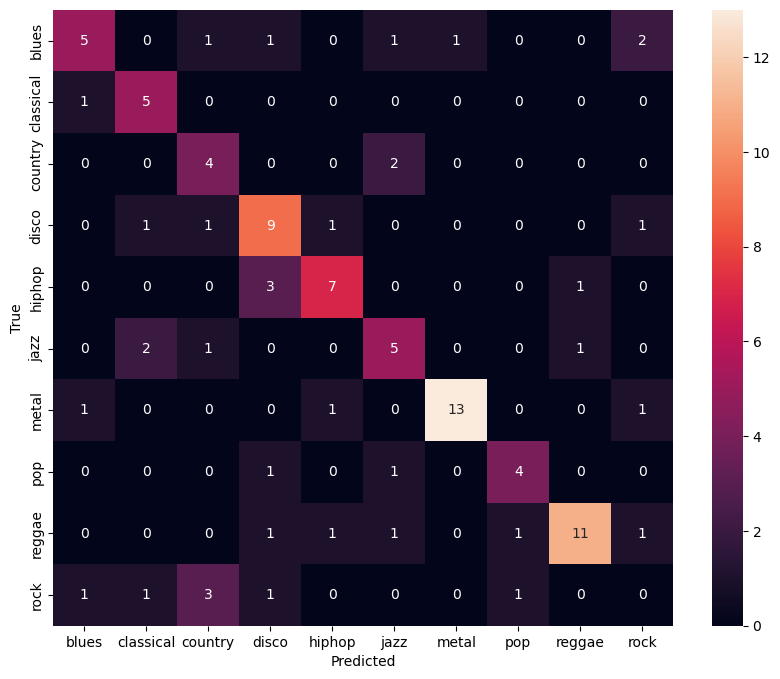

In [42]:
# Create confusion matrix
def get_confusion_matrix(model8, test_loader, num_classes):
    model8.eval()
    confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='multiclass')
    confusion_matrix.cuda()  
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model8(images)
            _, predicted = torch.max(outputs, 1)
            confusion_matrix.update(predicted, labels)

    return confusion_matrix.compute().cpu().numpy()

# Make sure put the right number in it
num_classes = len(dataset.classes)  
conf_matrix = get_confusion_matrix(model8, test_loader, num_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')

In [8]:
!pip install session-info

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 79.8/79.8 kB 2.2 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8037 sha256=ae4e407a269c2280758522e16c67e676b3ed1f9088deef8ff1be12513533b440
  Stored in directory: c:\users\ricky\appdata\local\pip\cache\wheels\d4\fc\2e\00ca60bac7954b84907efd41baa9b4853500eaeec4228410c6
Successfully built session-info


In [9]:
import session_info
session_info.show()